---

**Task**

- 다양한 시계열 과업(에측, 이상치 탐지, 분류)들에 대한 프레임워크 구성

**Dataset**

- 예측(ETTh1), 이상치 탐지(PSM), 분류(UEA)의 벤치마크 데이터셋 이용

**Code**

- 모든 과업 수행에 대해서 사용가능한 데이터셋 구성 및 모델링 진행하며, 성능 평가 가능한지 확인
- 데이터 분석 및 전처리 - 데이터셋 및 로더 구성 - 모델 구축 및 학습 - 성능 평가 및 결과 해석
- 기존 모델 코드 그대로 사용 금지

**Submit**

- 모든 과정에 대한 명확한 근거와 설명 문서화
- 실험 결과의 로깅 및 시각화
- 제출 파일은 README, 주피터 노트북 형태로 개인 repo에 push 한 다음 repo 링크를 제출

---

## 초기설정

In [20]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [21]:
# 필요 라이브러리 설치
!pip install omegaconf
!pip install aeon
!pip install numba
!pip install awkward

In [22]:
# 기본 라이브리러리
import torch
from torch.utils.data import DataLoader

import numpy as np
import os
import json
import shutil
import logging
import warnings
warnings.filterwarnings("ignore")

from glob import glob

from accelerate import Accelerator, DistributedDataParallelKwargs
from accelerate.logging import get_logger
from accelerate.utils import set_seed

from omegaconf import OmegaConf

################### 추가 라이브러리(이용시) ######################

import pandas as pd
import aeon
from scipy import stats
from scipy.signal import periodogram
from scipy.io import arff
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from aeon.datasets import load_from_ts_file
from statsmodels.tsa.seasonal import seasonal_decompose
import awkward as ak
from numba import jit, njit, prange
import time
import torch.nn.functional as F
import math
import copy
import json
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader




############################################################

---

In [23]:
# Training argument
config = {
    "DEFAULT": {
        "exp_name": "forecasting",
        "seed": 42
    },
    "DATASET": {
        "taskname": "long_term_forecast",
        "dataname": "custom",
        "sub_data_name": None,
        "scaler": "standard",
        "window_size": 96,
        "label_len": 0,
        "pred_len": 96,
        "model_type": "forecasting",
        "pretrain": False,
        "split_rate": [0.7, 0.1, 0.2],
        "timeenc": 0,
        "freq": "h",
        "embed_type": "learned"
    },
    "DATAINFO": {
        "datadir": "./dataset",
        "train_path": "",
        "valid_path": "",
        "test_path": "",
        "test_label_path": ""
    },
    "TRAIN": {
        "epoch": 30,
        "batch_size": 64,
        "test_batch_size": 128,
        "num_workers": 0,
        "ckp_metric": "MSE",
        "eval_epochs": 1,
        "log_epochs": 1,
        "log_eval_iter": 50,
        "shuffle": False,
        "pin_memory": True,
        "resume": False,
        "resume_number": 0,
        "early_stopping_metric": "loss",
        "early_stopping_count": 20,
        "return_output": True,
        "lradj": "type1",
        "wandb": {
            "use": False,
            "iter": 50,
            "exp_name": "default",
            "project_name": "TMAE",
            "entity": "A"
        }
    },
    "LOSS": {
        "loss_name": "MSELoss"
    },
    "OPTIMIZER": {
        "opt_name": "AdamW",
        "lr": 0.0001,
        "params": {
            "weight_decay": 0.0005
        }
    },
    "RESULT": {
        "savedir": "./saved_model"
    }
}

# Model arguments
models_config = {
        "MyDiffusionModel": {
        "input_size": 16,       # 입력 피처 수
        "hidden_size": 16,     # 히든 차원
        "num_layers": 1,       # 계층 수
        "dropout": 0.2,        # 드롭아웃 비율
        "enc_in": 16,
        "seq_len" : 336,
        "d_model" : 16,
        "output_size": 1       # 출력 차원(예: 회귀라면 1)

        }
##################### EDIT YOUR CODE #########################
# EX)
#     "YOUR_MODEL": {
#         "enc_in": 125,
#         "dropout": 0.1
#     }
##############################################################
}

cfg = OmegaConf.create(config)

##################### EDIT YOUR CODE #########################
# EX)
# cfg = OmegaConf.merge(cfg, {'MODEL':{'modelname' : 'YOUR_MODEL'}})
##############################################################
cfg = OmegaConf.merge(cfg, {'MODEL':{'modelname' : 'MyDiffusionModel'}})



model_cfg = OmegaConf.create(models_config)
modelname = cfg.MODEL.modelname

if modelname in model_cfg:
    model_setting_conf = OmegaConf.create(model_cfg[cfg.MODEL.modelname])
    cfg = OmegaConf.merge(cfg, {'MODELSETTING' : model_setting_conf})
else:
    print(f"Model '{modelname}' not found in the model_config.")


In [24]:
base_cfg = OmegaConf.create(config)

def build_task_cfg(
    base_cfg,
    models_config,
    taskname,
    dataname,
    loss_name,
    modelname,
    data_info_update=None,
    dataset_update=None,
):
    # 1. base에서 복제 및 task 정보 덮어쓰기
    update_dict = {
        'DATASET': {'taskname': taskname, 'dataname': dataname},
        'DATAINFO': {'dataname': dataname},
        'LOSS': {'loss_name': loss_name},
        'MODEL': {'modelname': modelname},
    }
    if data_info_update:
        update_dict['DATAINFO'].update(data_info_update)
    if dataset_update:
        update_dict['DATASET'].update(dataset_update)
    # base merge
    cfg = OmegaConf.merge(base_cfg, update_dict)

    # 2. 모델 세부 파라미터 자동 merge
    model_cfg = OmegaConf.create(models_config)
    if modelname in model_cfg:
        model_setting_conf = OmegaConf.create(model_cfg[modelname])
        cfg = OmegaConf.merge(cfg, {'MODELSETTING': model_setting_conf})
    else:
        print(f"Model '{modelname}' not found in the model_config.")

    return cfg

# ==== 사용 예시 ====

base_cfg = OmegaConf.create(config)

forecast_cfg = build_task_cfg(
    base_cfg, models_config,
    taskname='long_term_forecast',
    dataname='ETTh1',
    loss_name='MSELoss',
    modelname='MyDiffusionModel'
)

anomaly_cfg = build_task_cfg(
    base_cfg, models_config,
    taskname='anomaly_detection',
    dataname='PSM',
    loss_name='BCELoss',
    modelname='MyDiffusionModel'
)

classification_cfg = build_task_cfg(
    base_cfg, models_config,
    taskname='classification',
    dataname='Libras',
    loss_name='CrossEntropyLoss',
    modelname='MyDiffusionModel'
)


---

In [25]:
def make_save(accelerator, savedir: str, resume: bool = False) -> str:
    # resume
    if resume:
        assert os.path.isdir(savedir), f'{savedir} does not exist'
        # check version
        version = len([f for f in glob.glob(os.path.join(savedir, '*')) if os.path.isdir(f)])
        # init version
        if version == 0:
            files = [f for f in glob.glob(os.path.join(savedir, '*')) if os.path.isfile(f)]
            version0_dir = os.path.join(savedir, f'train{version}')

            accelerator.wait_for_everyone()
            if accelerator.is_main_process:
                os.makedirs(version0_dir)
                for f in files:
                    shutil.move(f, f.replace(savedir, version0_dir))
            version += 1

        savedir = os.path.join(savedir, f'train{version}')
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        os.makedirs(savedir, exist_ok=True)
    print("make save directory {}".format(savedir))

    return savedir


In [26]:
_logger = get_logger('train')

# set seed
set_seed(cfg.DEFAULT.seed)

# set accelrator
accelerator = Accelerator()

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
    )

# make save directory
savedir = os.path.join(cfg.RESULT.savedir, cfg.MODEL.modelname, cfg.DEFAULT.exp_name)
savedir = make_save(accelerator = accelerator, savedir=savedir, resume=cfg.TRAIN.resume)

# set device
_logger.info('Device: {}'.format(accelerator.device), main_process_only=False)

make save directory ./saved_model/MyDiffusionModel/forecasting


## 1. 데이터 분석 및 전처리

    1-1) 제공된 데이터에 기본적인 분석 진행 (통계량 분석, 결측치 확인, 정상성 분석, 시계열 분해 등)
    1-2) 확인된 특성을 반영하여 전처리 진행 (이상치 처리, 결측치 처리, 정규화 등)
    1-3) 전처리된 데이터를 바탕으로 다시 한번 분석 진행 후 수정된 부분 기술 (통계량 분석, 결측치 확인, 정상성 분석, 시계열 분해 등)
    1-4) 수정 내용을 반영하며, create_dataloader_default에 기술된 argument가 포함될 수 있도록 함수 작성
    1-5) Argument가 기재된 의도를 파악하여 최대한 많은 argument사용하여 작성
    1-6) Pytorch 라이브러리를 통하여 모델링 가능하게끔 데이터셋 구성 및 로더 구성
    1-7) 데이터셋 구성 중, 간격이 달라지는 시점이 존재한다면 해당 부분은 데이터셋으로 구성되지 않도록 구성

In [27]:
def load_dataset(cfg):
    data_dir = cfg.DATAINFO.datadir
    dataset = cfg.DATAINFO.dataname.lower()

    if dataset.startswith('ett'):
        file_path = os.path.join(data_dir, 'ETT-small', f'{cfg.DATAINFO.dataname}.csv')
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
        return df

    elif dataset == 'psm':
        train_file = os.path.join(data_dir, 'PSM', 'train.csv')
        test_file = os.path.join(data_dir, 'PSM', 'test.csv')
        df_train = pd.read_csv(train_file, parse_dates=['timestamp_(min)'], index_col='timestamp_(min)')
        df_test = pd.read_csv(test_file, parse_dates=['timestamp_(min)'], index_col='timestamp_(min)')
        return df_train, df_test

    elif dataset in ['articularywordrecognition', 'libras']:
        folder = os.path.join(data_dir, 'UEA', cfg.DATAINFO.dataname)
        train_path = os.path.join(folder, f'{cfg.DATAINFO.dataname}_TRAIN.ts')
        test_path = os.path.join(folder, f'{cfg.DATAINFO.dataname}_TEST.ts')
        X_train, y_train = load_from_ts_file(train_path)
        X_test, y_test = load_from_ts_file(test_path)
        return (X_train, y_train), (X_test, y_test)

    else:
        raise ValueError(f"Unknown dataset: {dataset}")


In [28]:
def basic_analysis(data, name=""):
    print(f"\n==== [{name}] 기본 통계 분석 ====")
    if isinstance(data, pd.DataFrame):
        print(data.describe())
        print("\n결측치 개수:\n", data.isnull().sum())
        num_cols = data.select_dtypes(include=np.number).columns
        print("\n정상성(ADF) 테스트 (샘플 3개 컬럼만):")
        for col in list(num_cols)[:3]:
            try:
                from statsmodels.tsa.stattools import adfuller
                adf_result = adfuller(data[col].dropna())
                print(f"{col}: p-value={adf_result[1]:.4f} {'정상' if adf_result[1] < 0.05 else '비정상'}")
            except Exception as e:
                print(f"{col}: ADF error: {e}")
    elif isinstance(data, np.ndarray):
        print(f"shape: {data.shape}")
        print("전체 평균:", np.mean(data))
        print("전체 표준편차:", np.std(data))
        print("전체 결측치 개수:", np.isnan(data).sum())
        # 예시로 앞 3개 변수만 정상성 검사
        if data.shape[1] >= 1 and data.shape[2] >= 5:
            print("\n정상성(ADF) 테스트 (변수 3개만):")
            for j in range(min(3, data.shape[1])):
                try:
                    from statsmodels.tsa.stattools import adfuller
                    adf_result = adfuller(data[:, j, :][0])  # 첫 샘플의 j번째 변수 시계열
                    print(f"var{j}: p-value={adf_result[1]:.4f} {'정상' if adf_result[1] < 0.05 else '비정상'}")
                except Exception as e:
                    print(f"var{j}: ADF error: {e}")
    else:
        print(f"[WARNING] Unknown data type: {type(data)}")


In [29]:
def preprocess(data, scaler_type="standard", outlier_thresh=3):
    def print_outlier_counts(df, label):
        num_cols = df.select_dtypes(include=np.number).columns
        total_outlier_count = 0
        print(f"[이상치 개수] ({label})")
        for col in num_cols:
            col_z = (df[col] - df[col].mean()) / (df[col].std() + 1e-6)
            outlier_count = (col_z.abs() > outlier_thresh).sum()
            total_outlier_count += outlier_count
            print(f"  - {col}: {outlier_count}개")
        print(f"전체 이상치 개수: {total_outlier_count}\n")

    if isinstance(data, pd.DataFrame):
        df_proc = data.copy()
        df_proc = df_proc.fillna(0)
        # 전처리 전 이상치 개수 출력
        print_outlier_counts(df_proc, label="전처리 전")
        # 이상치 0으로 대체
        num_cols = df_proc.select_dtypes(include=np.number).columns
        for col in num_cols:
            col_z = (df_proc[col] - df_proc[col].mean()) / (df_proc[col].std() + 1e-6)
            df_proc.loc[col_z.abs() > outlier_thresh, col] = 0
        # 정규화
        if scaler_type == "standard":
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])
        elif scaler_type == "minmax":
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])
        # 전처리 후 이상치 개수 출력
        print_outlier_counts(df_proc, label="전처리 후")
        return df_proc

    elif isinstance(data, np.ndarray):
        arr = data.copy()
        arr = np.where(np.isnan(arr), 0, arr)
        # 전처리 전 이상치 개수 출력
        m, s = arr.mean(), arr.std()
        z = (arr - m) / (s + 1e-6)
        outlier_mask = np.abs(z) > outlier_thresh
        print(f"전체 이상치 개수 (ndarray, 전처리 전): {outlier_mask.sum()}\n")
        arr[outlier_mask] = 0
        # 정규화
        if scaler_type == "standard":
            arr = (arr - m) / (s + 1e-6)
        elif scaler_type == "minmax":
            arr_min, arr_max = arr.min(), arr.max()
            arr = (arr - arr_min) / (arr_max - arr_min + 1e-6)
        # 전처리 후 이상치 개수 출력
        m2, s2 = arr.mean(), arr.std()
        z2 = (arr - m2) / (s2 + 1e-6)
        outlier_mask2 = np.abs(z2) > outlier_thresh
        print(f"전체 이상치 개수 (ndarray, 전처리 후): {outlier_mask2.sum()}\n")
        return arr

    else:
        print(f"[WARNING] Unknown data type: {type(data)}")
        return data


In [30]:
def analyze_and_preprocess(cfg):
    loaded = load_dataset(cfg)
    dfs = []
    names = []
    if isinstance(loaded, tuple):
        for data in loaded:
            if isinstance(data, tuple) and len(data) == 2:
                X, y = data
                dfs.append((X, y))
                names.append('Train' if len(dfs) == 1 else 'Test')
            else:
                dfs.append(data)
                names.append(cfg.DATAINFO.dataname)
    else:
        dfs = [loaded]
        names = [cfg.DATAINFO.dataname]

    results = []
    for (data, name) in zip(dfs, names):
        print("\n==============================")
        print(f"1차 분석({name})")
        # X, y 분리
        if isinstance(data, tuple) and len(data) == 2:
            X, y = data
            basic_analysis(X, name=f"{name} (X)")
            print("\n[라벨 분포]")
            print(pd.Series(y).value_counts())
            print("\n전처리 중...")
            X_proc = preprocess(X, scaler_type=cfg.DATASET.scaler)
            basic_analysis(X_proc, name=f"{name} (X, 전처리)")
            results.append((X_proc, y))
        else:
            basic_analysis(data, name=name)
            print("\n전처리 중...")
            data_proc = preprocess(data, scaler_type=cfg.DATASET.scaler)
            basic_analysis(data_proc, name=f"{name} (전처리)")
            results.append(data_proc)

    if len(results) == 0:
        raise RuntimeError("No valid data found for analysis/processing. Check your data structure!")
    return tuple(results) if len(results) > 1 else results[0]


In [31]:
cfg = forecast_cfg
df_processed = analyze_and_preprocess(cfg)


1차 분석(ETTh1)

==== [ETTh1] 기본 통계 분석 ====
               HUFL          HULL          MUFL          MULL          LUFL  \
count  17420.000000  17420.000000  17420.000000  17420.000000  17420.000000   
mean       7.375141      2.242242      4.300239      0.881568      3.066062   
std        7.067744      2.042342      6.826978      1.809293      1.164506   
min      -22.705999     -4.756000    -25.087999     -5.934000     -1.188000   
25%        5.827000      0.737000      3.296000     -0.284000      2.315000   
50%        8.774000      2.210000      5.970000      0.959000      2.833000   
75%       11.788000      3.684000      8.635000      2.203000      3.625000   
max       23.643999     10.114000     17.341000      7.747000      8.498000   

               LULL            OT  
count  17420.000000  17420.000000  
mean       0.856932     13.324672  
std        0.599552      8.566946  
min       -1.371000     -4.080000  
25%        0.670000      6.964000  
50%        0.975000     11.396

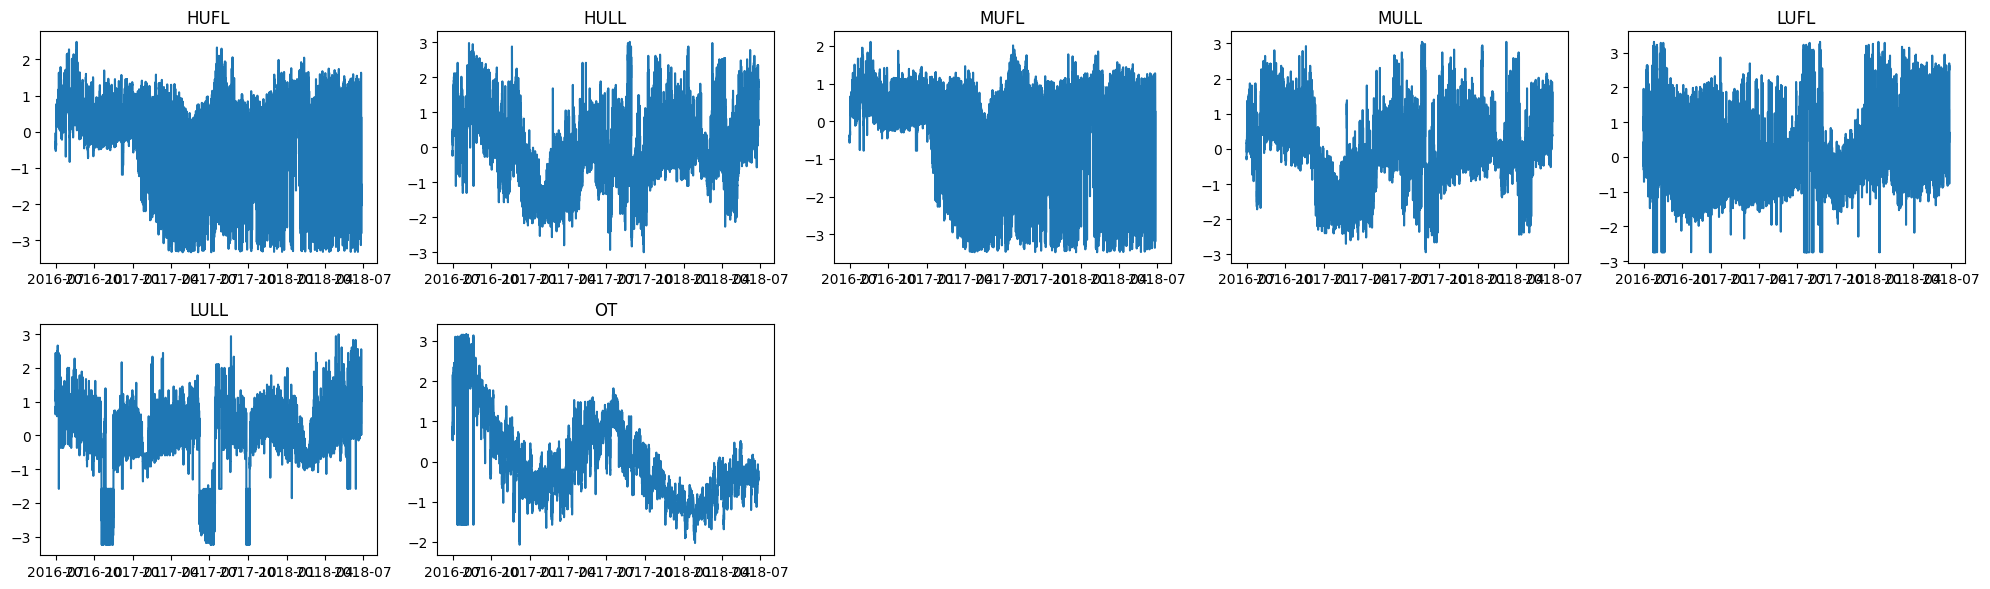

In [ ]:
def visualize_time_series(df, title="Time Series Visualization", n_cols=5, max_vars=10):
    """
    df: pd.DataFrame, index=Datetime, columns=features
    n_cols: 서브플롯 컬럼 수
    max_vars: 최대 몇 개 변수만 시각화할지
    """
    num_vars = min(df.shape[1], max_vars)
    n_rows = (num_vars + n_cols - 1) // n_cols
    plt.figure(figsize=(4*n_cols, 3*n_rows))
    for i, col in enumerate(df.columns[:num_vars]):
        plt.subplot(n_rows, n_cols, i+1)
        plt.plot(df.index, df[col])
        plt.title(col)
        plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# 사용 예시
visualize_time_series(df_processed, title="")


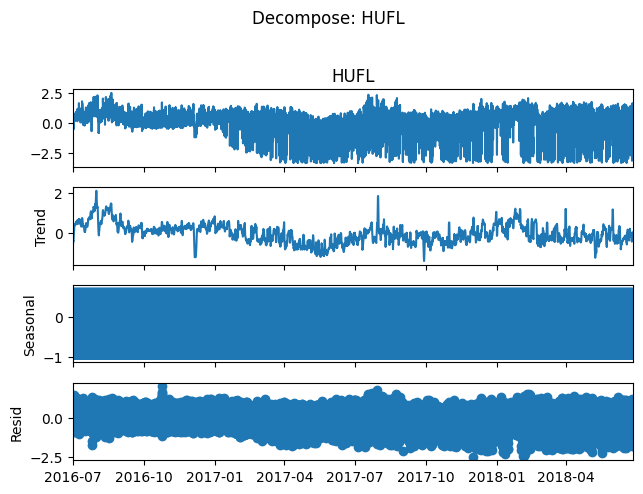

In [ ]:
def decompose_and_plot(df, col='OT', freq=24):
    """
    df: 전처리된 DataFrame
    col: 분해할 컬럼명 (ex: 'OT')
    freq: 계절성 주기 (예: 시간별이면 24, 일별이면 7 등)
    """
    if col not in df.columns:
        print(f"{col} 컬럼이 없습니다. 다른 컬럼명 입력 or col=df.columns[0]로 변경")
        col = df.columns[0]
    series = df[col]
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"Decompose: {col}", y=1.02)
    plt.tight_layout()
    plt.show()

# 사용 예시
decompose_and_plot(df_processed, col="HUFL", freq=24)


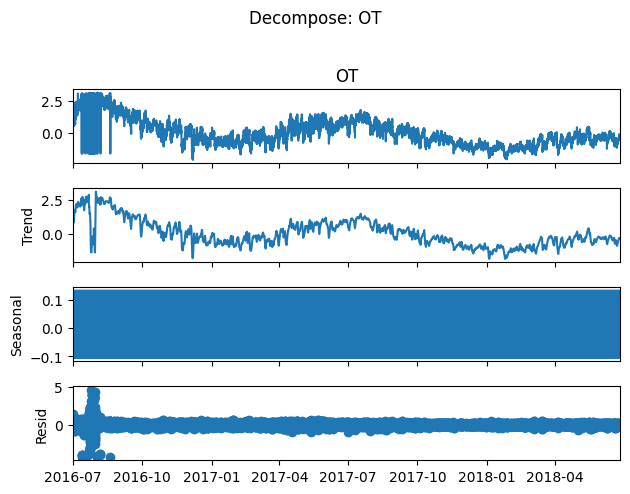

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decompose_and_plot(df, col='OT', freq=24):
    """
    df: 전처리된 DataFrame
    col: 분해할 컬럼명 (ex: 'OT')
    freq: 계절성 주기 (예: 시간별이면 24, 일별이면 7 등)
    """
    if col not in df.columns:
        print(f"{col} 컬럼이 없습니다. 다른 컬럼명 입력 or col=df.columns[0]로 변경")
        col = df.columns[0]
    series = df[col]
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"Decompose: {col}", y=1.02)
    plt.tight_layout()
    plt.show()

# 사용 예시
decompose_and_plot(df_processed, col="OT", freq=24)


In [ ]:
# PSM (이상치 탐지)
cfg = anomaly_cfg
df_train_proc, df_test_proc = analyze_and_preprocess(cfg)


1차 분석(PSM)

==== [PSM] 기본 통계 분석 ====
           feature_0      feature_1      feature_2      feature_3  \
count  132481.000000  132481.000000  132481.000000  132481.000000   
mean        0.835810       0.840205       0.634216       0.575081   
std         0.067326       0.039472       0.102920       0.049675   
min         0.486490       0.525682       0.421484       0.380874   
25%         0.789497       0.820488       0.580170       0.543702   
50%         0.837290       0.843873       0.603304       0.572077   
75%         0.880603       0.866423       0.625805       0.611127   
max         1.000000       0.909956       1.000000       0.676682   

           feature_4      feature_5      feature_6      feature_7  \
count  132279.000000  132232.000000  131918.000000  132434.000000   
mean        0.543310       0.511753       0.549268       0.537706   
std         0.089438       0.077771       0.064093       0.090120   
min         0.065106       0.110161       0.215909       0.07779

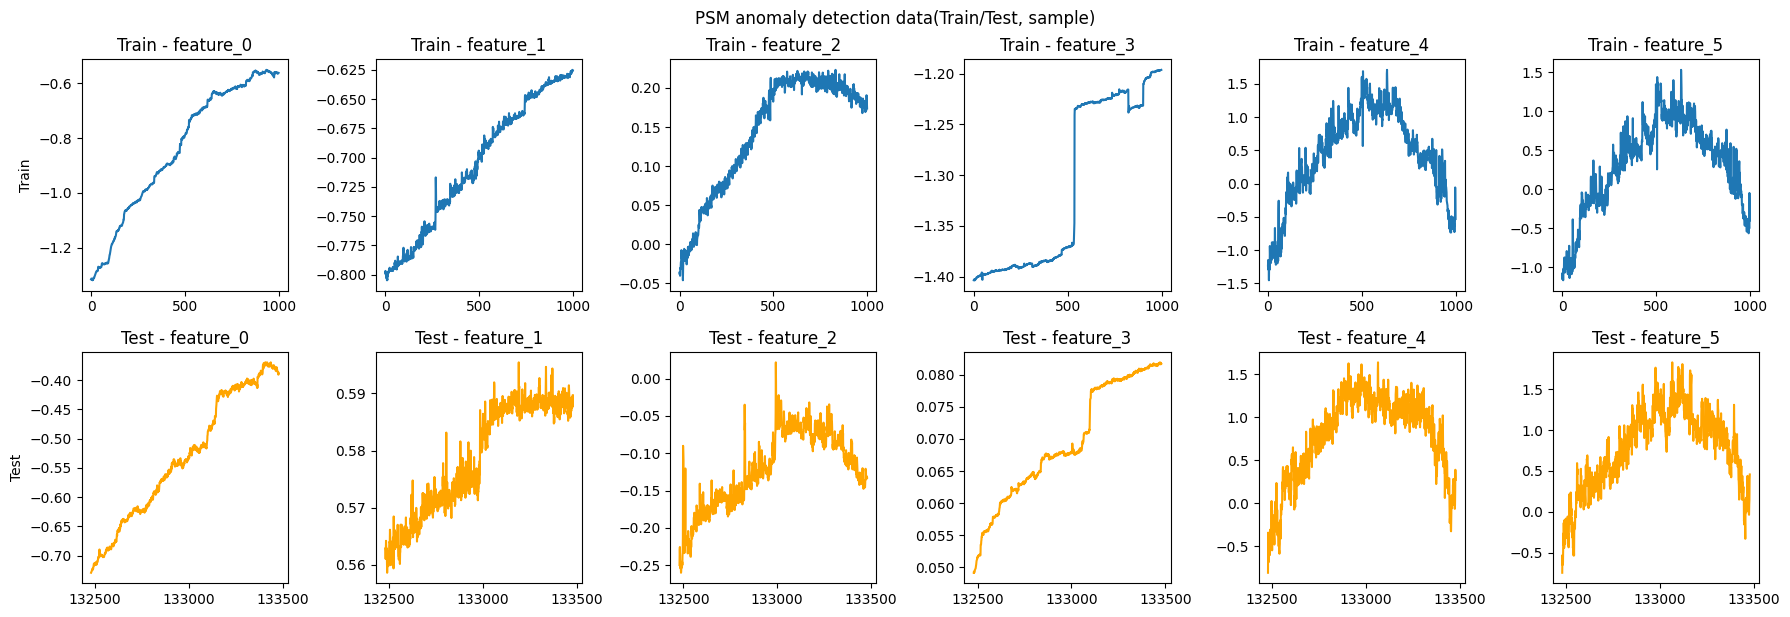

In [ ]:
def visualize_psm(df_train, df_test, max_vars=6, sample_len=1000):
    """
    PSM 이상치 탐지 데이터 시각화
    - max_vars: 최대 몇 개 변수만 시각화
    - sample_len: 앞에서 얼마만큼만 시각화 (너무 길면 cut)
    """
    cols = df_train.columns[:max_vars]
    plt.figure(figsize=(18, 6))

    for i, col in enumerate(cols):
        plt.subplot(2, max_vars, i+1)
        plt.plot(df_train.index[:sample_len], df_train[col].values[:sample_len], label="Train")
        plt.title(f"Train - {col}")
        if i == 0: plt.ylabel("Train")
        plt.tight_layout()

        plt.subplot(2, max_vars, max_vars+i+1)
        plt.plot(df_test.index[:sample_len], df_test[col].values[:sample_len], label="Test", color="orange")
        plt.title(f"Test - {col}")
        if i == 0: plt.ylabel("Test")
        plt.tight_layout()
    plt.suptitle("PSM anomaly detection data(Train/Test, sample)", y=1.02)
    plt.show()

# 사용 예시
visualize_psm(df_train_proc, df_test_proc)


=== [Train] feature_0 ===


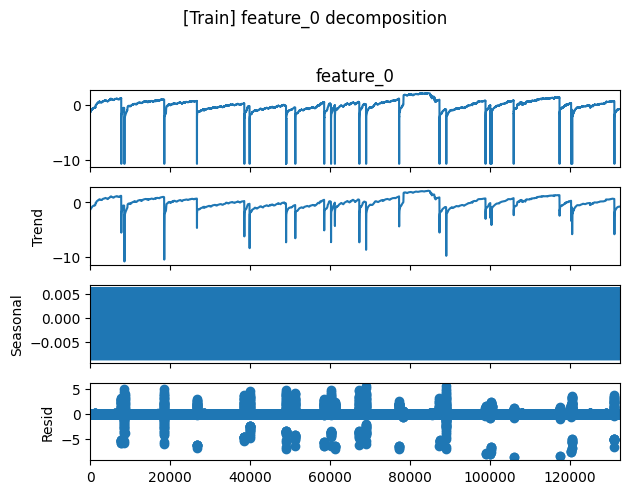

=== [Train] feature_1 ===


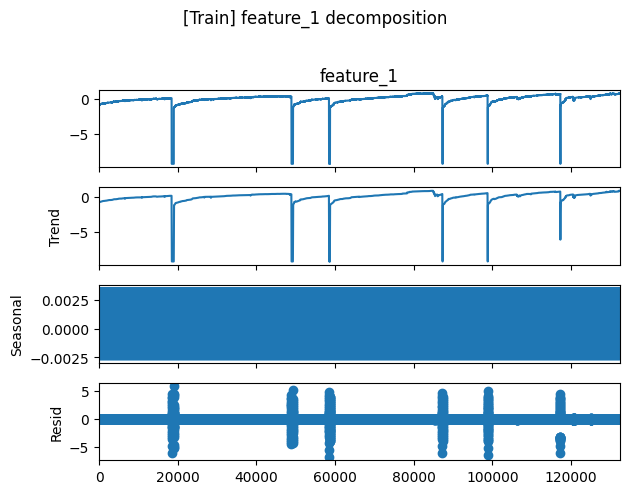

=== [Train] feature_2 ===


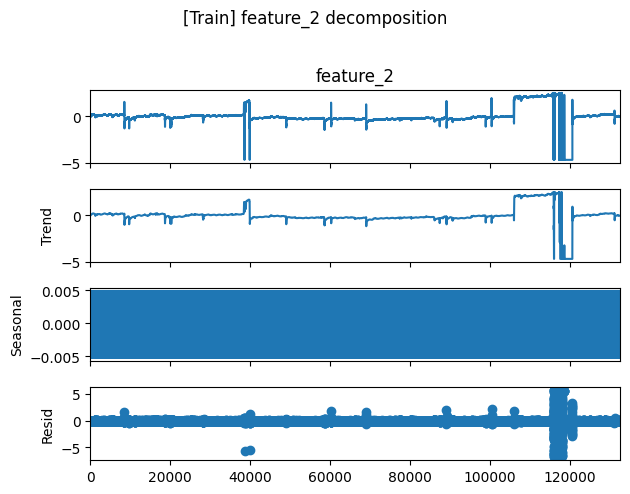

=== [Test] feature_0 ===


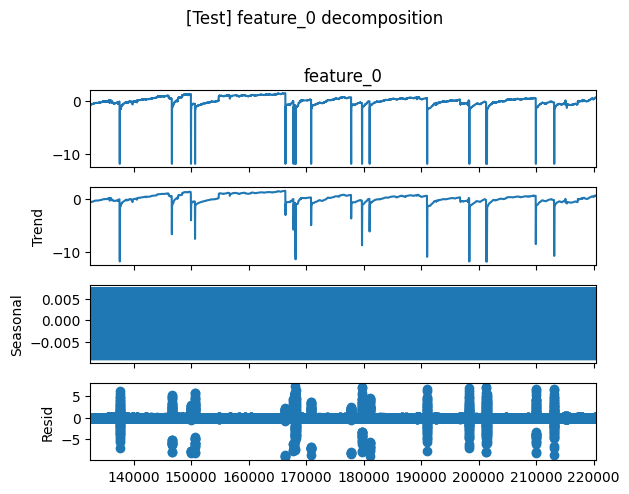

=== [Test] feature_1 ===


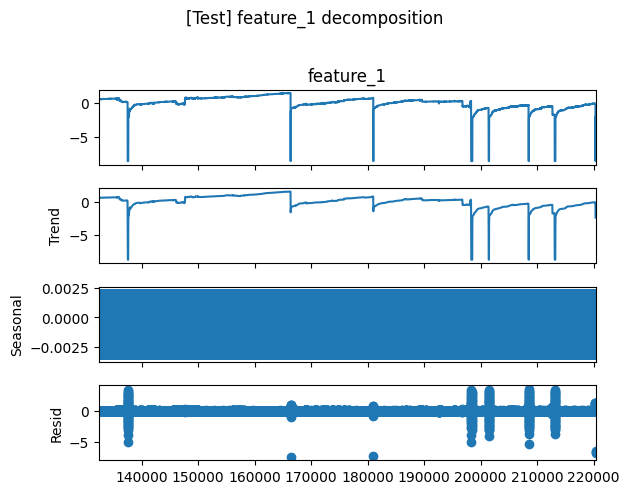

=== [Test] feature_2 ===


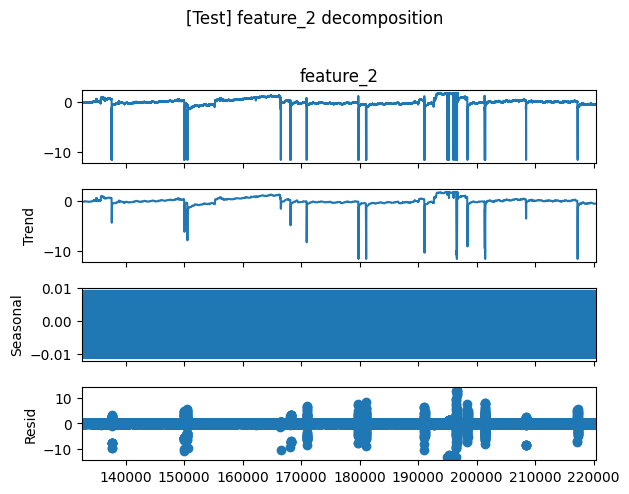

In [ ]:
def decompose_and_plot(df, col=None, freq=24, title_prefix=""):
    """
    df: 시계열 DataFrame (index=Datetime, columns=feature)
    col: 분해할 컬럼명 (없으면 첫 번째 컬럼)
    freq: 계절성 주기 (예: 24=일간, 168=주간)
    title_prefix: 그래프 제목 접두사
    """
    if col is None or col not in df.columns:
        col = df.columns[0]  # 자동 선택
    series = df[col]
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"{title_prefix}{col} decomposition", y=1.02)
    plt.tight_layout()
    plt.show()

# 예시: train/test에서 주요 변수 각각 분해
target_cols = df_train_proc.columns[:3]  # 앞 3개 변수만 예시 (변수 많으면 조정)

for col in target_cols:
    print(f"=== [Train] {col} ===")
    decompose_and_plot(df_train_proc, col=col, freq=24, title_prefix="[Train] ")
for col in target_cols:
    print(f"=== [Test] {col} ===")
    decompose_and_plot(df_test_proc, col=col, freq=24, title_prefix="[Test] ")


In [42]:
# UEA Libras (분류)
cfg = classification_cfg
(train_X_proc, train_y), (test_X_proc, test_y) = analyze_and_preprocess(cfg)


1차 분석(Train)

==== [Train (X)] 기본 통계 분석 ====
shape: (180, 2, 45)
전체 평균: 0.5142851352469137
전체 표준편차: 0.17931758625170993
전체 결측치 개수: 0

정상성(ADF) 테스트 (변수 3개만):
var0: p-value=0.0000 정상
var1: p-value=0.0036 정상

[라벨 분포]
1     12
2     12
3     12
4     12
5     12
6     12
7     12
8     12
9     12
10    12
11    12
12    12
13    12
14    12
15    12
Name: count, dtype: int64

전처리 중...
전체 이상치 개수 (ndarray, 전처리 전): 0

전체 이상치 개수 (ndarray, 전처리 후): 0


==== [Train (X, 전처리)] 기본 통계 분석 ====
shape: (180, 2, 45)
전체 평균: -4.631685981251023e-16
전체 표준편차: 0.9999944233332366
전체 결측치 개수: 0

정상성(ADF) 테스트 (변수 3개만):
var0: p-value=0.0000 정상
var1: p-value=0.0036 정상

1차 분석(Test)

==== [Test (X)] 기본 통계 분석 ====
shape: (180, 2, 45)
전체 평균: 0.5092754867283951
전체 표준편차: 0.17783484471351937
전체 결측치 개수: 0

정상성(ADF) 테스트 (변수 3개만):
var0: p-value=0.0011 정상
var1: p-value=0.0013 정상

[라벨 분포]
1     12
2     12
3     12
4     12
5     12
6     12
7     12
8     12
9     12
10    12
11    12
12    12
13    12
14    12
15    12
Name

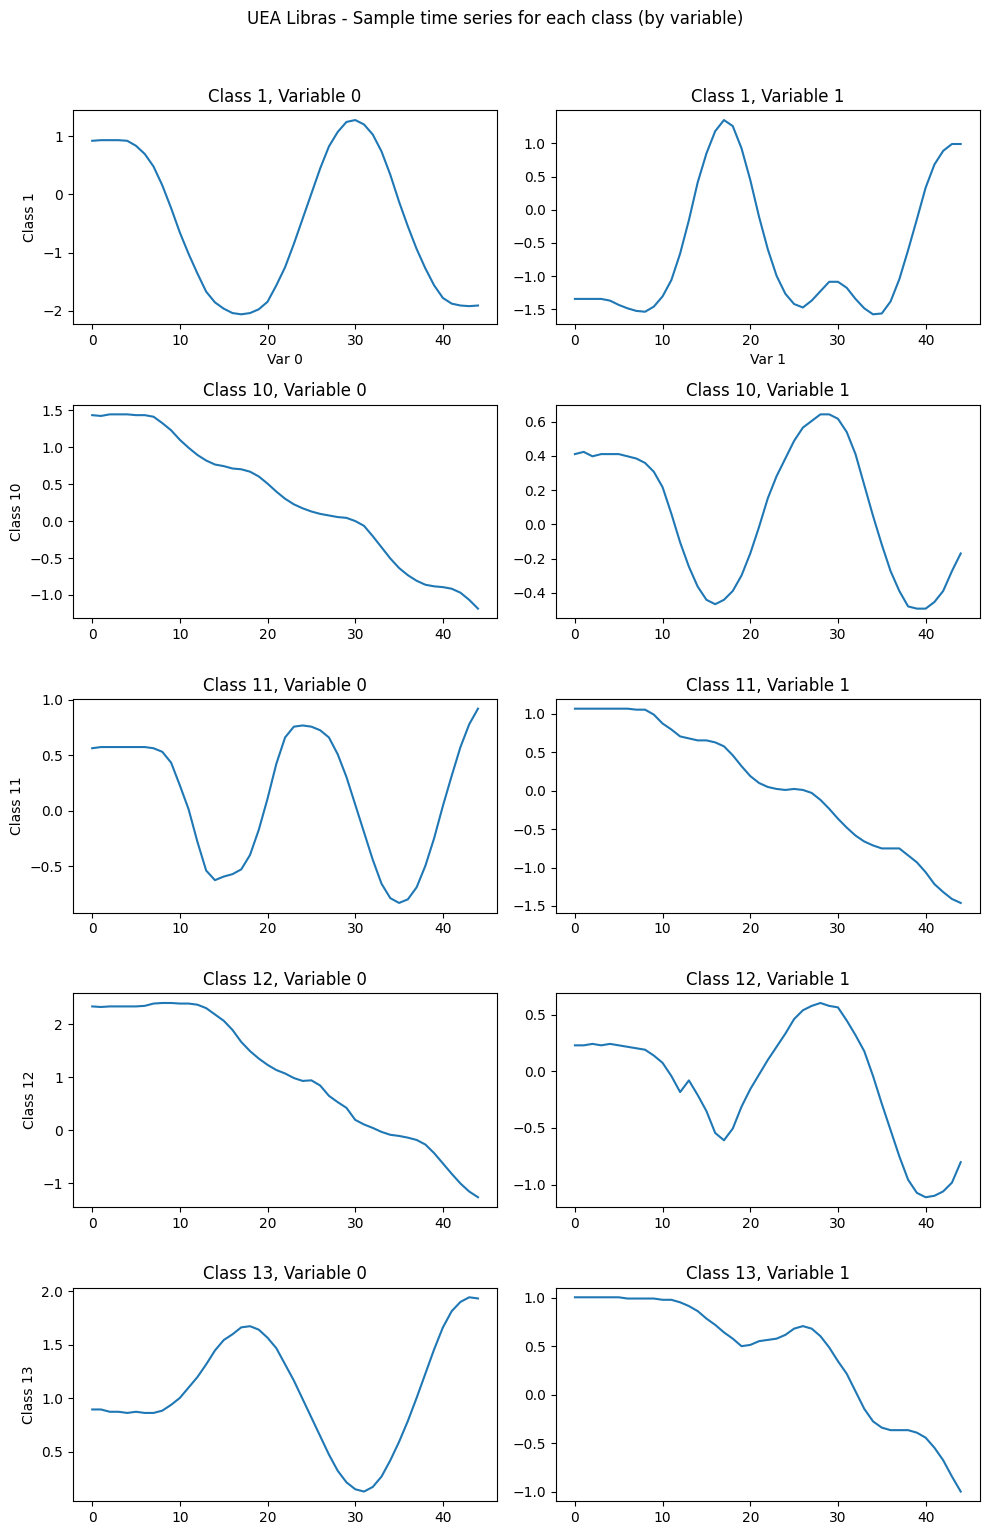

In [ ]:
def visualize_uea_multivariate(X, y, n_classes=5, max_vars=2):
    """
    X: (n_samples, n_vars, seq_len) np.ndarray 또는 (n_samples, n_vars) DataFrame (cell=Series)
    y: (n_samples,) array-like (class labels)
    n_classes: 몇 개 클래스만 시각화 (클래스별 첫 샘플)
    max_vars: 몇 개 변수(채널)까지 subplot (각 시계열 변수별)

    예시: 클래스별(최대 n_classes개)로, 변수별(max_vars개) 시계열을 그린다.
    """
    # DataFrame이면 ndarray로 변환
    if isinstance(X, np.ndarray):
        arr = X
    elif isinstance(X, pd.DataFrame):
        n_samples, n_vars = X.shape
        seq_len = len(X.iloc[0,0])
        arr = np.empty((n_samples, n_vars, seq_len))
        for i in range(n_samples):
            for j in range(n_vars):
                arr[i, j, :] = X.iloc[i, j].values
    else:
        raise ValueError("지원하지 않는 X 타입입니다.")

    classes = np.unique(y)
    n_plots = min(n_classes, len(classes))
    n_vars = min(arr.shape[1], max_vars)
    plt.figure(figsize=(5*n_vars, 3*n_plots))
    for i, cls in enumerate(classes[:n_plots]):
        idx = np.where(y == cls)[0][0]  # 해당 클래스의 첫 샘플 index
        for j in range(n_vars):
            plt.subplot(n_plots, n_vars, i*n_vars + j + 1)
            plt.plot(arr[idx, j, :])
            plt.title(f"Class {cls}, Variable {j}")
            if j == 0: plt.ylabel(f"Class {cls}")
            if i == 0: plt.xlabel(f"Var {j}")
    plt.suptitle("UEA Libras - Sample time series for each class (by variable)", y=1.02)
    plt.tight_layout()
    plt.show()

# 사용 예시
visualize_uea_multivariate(train_X_proc, train_y, n_classes=5, max_vars=2)


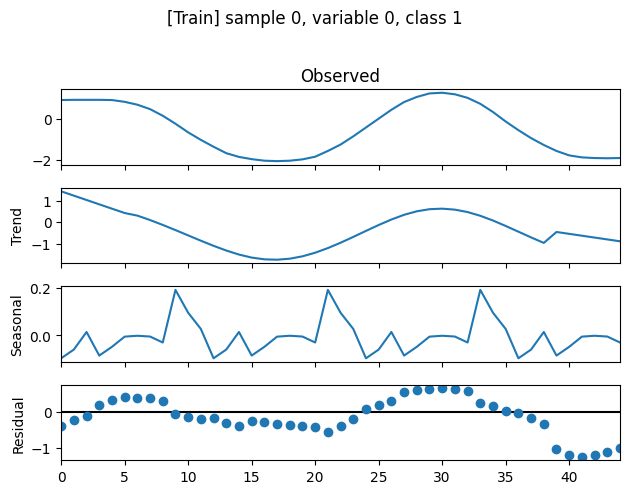

In [ ]:
def decompose_sample_time_series(X, y, sample_idx=0, var_idx=0, freq=12, title_prefix=""):
    """
    X: (n_samples, n_vars, seq_len) ndarray or DataFrame
    y: (n_samples,)
    sample_idx: 분해할 샘플 인덱스
    var_idx: 분해할 변수(채널) 인덱스
    freq: 계절성 주기 (예: 12=1년/12개월, 데이터 상황 맞게)
    """
    # DataFrame 형태라면 ndarray로 변환
    if isinstance(X, pd.DataFrame):
        series = X.iloc[sample_idx, var_idx].values
    elif isinstance(X, np.ndarray):
        series = X[sample_idx, var_idx, :]
    else:
        raise ValueError("지원하지 않는 X 타입입니다.")

    # 시계열 분해
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"{title_prefix}sample {sample_idx}, variable {var_idx}, class {y[sample_idx]}", y=1.02)
    plt.tight_layout()
    plt.show()

# 예시: 학습 데이터 첫 번째 샘플, 첫 번째 변수, freq=12로 분해
decompose_sample_time_series(train_X_proc, train_y, sample_idx=0, var_idx=0, freq=12, title_prefix="[Train] ")

###Awkward array 및 numba 사용 데모


ETTh1 데이터를 활용한 Awkward Array & Numba 쇼케이스
[INFO] 성공적으로 ./dataset/ETT-small/ETTh1.csv에서 데이터를 로드했습니다.

데이터 shape: (17420, 7)
컬럼: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

1. 이상치 탐지 성능 비교 (Python vs Numba)
Python 버전: 0.0071초
Numba 버전: 1.9245초
속도 향상: 0.0배 빨라짐!

각 컬럼별 이상치 개수:
  HUFL: 297개
  HULL: 41개
  MUFL: 366개
  MULL: 61개
  LUFL: 219개
  LULL: 323개
  OT: 159개

2. Awkward Array로 가변 길이 시계열 처리
생성된 시퀀스 개수: 719
시퀀스 길이 분포:
  최소: 24, 최대: 167, 평균: 96.6

각 피처별 평균값 (처음 5개 시퀀스):
  시퀀스 0: [9.200674632238963, 4.5311904852352445, 5.848079351205675] ... (처음 3개 피처만 표시)
  시퀀스 1: [10.225965540984582, 4.965758619637325, 6.8641120524242005] ... (처음 3개 피처만 표시)
  시퀀스 2: [10.468236923217773, 5.219131582661679, 7.031315753334447] ... (처음 3개 피처만 표시)
  시퀀스 3: [11.336623089130109, 5.009046138249911, 7.896746173271766] ... (처음 3개 피처만 표시)
  시퀀스 4: [11.292105253119217, 4.848642090747231, 7.872336874510113] ... (처음 3개 피처만 표시)

3. 데이터 정규화 성능 비교
Scikit-learn StandardScaler: 0.0021초
Numba 버전: 0.5689초
속도 향상: 

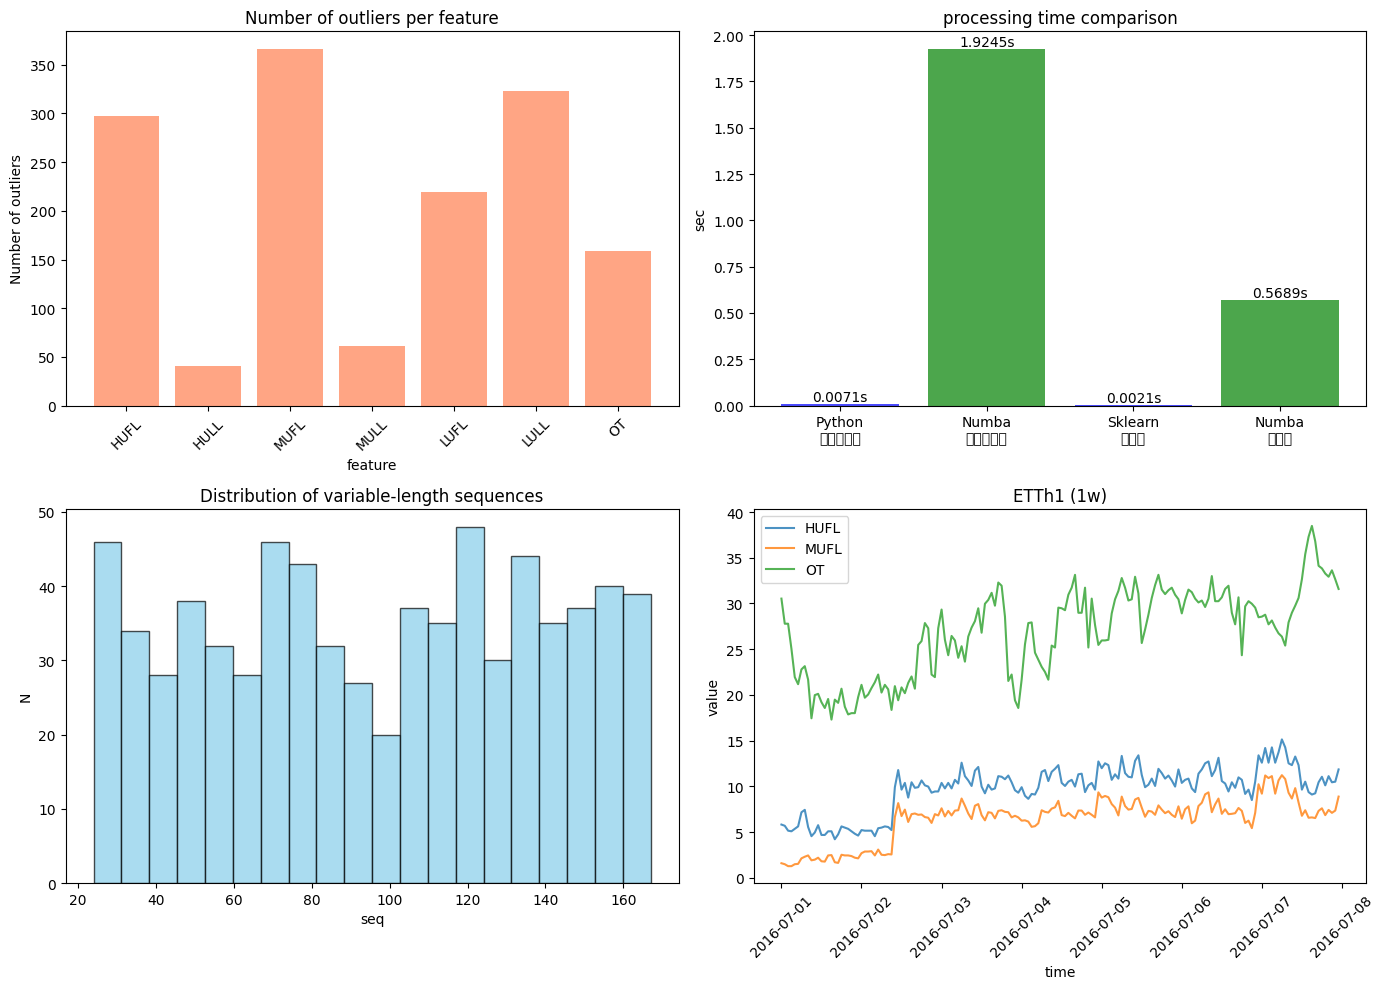

In [ ]:
# 제공된 전처리 함수들 (수정됨)
def load_dataset(cfg):
    # 하드코딩으로 직접 경로 지정
    file_path = './dataset/ETT-small/ETTh1.csv'
    try:
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
        print(f"[INFO] 성공적으로 {file_path}에서 데이터를 로드했습니다.")
        return df
    except FileNotFoundError:
        print(f"[WARNING] 파일을 찾을 수 없습니다: {file_path}")


# 1. Numba로 가속화된 이상치 탐지
@njit(parallel=True)
def fast_outlier_detection(data, threshold=3):
    """Numba로 가속화된 이상치 탐지"""
    n_samples, n_features = data.shape
    outlier_mask = np.zeros((n_samples, n_features), dtype=np.bool_)
    outlier_counts = np.zeros(n_features)

    for j in prange(n_features):
        col_data = data[:, j]
        mean = np.mean(col_data)
        std = np.std(col_data)

        for i in range(n_samples):
            if abs(col_data[i] - mean) > threshold * std:
                outlier_mask[i, j] = True
                outlier_counts[j] += 1

    return outlier_mask, outlier_counts

# 일반 Python 버전
def slow_outlier_detection(df, threshold=3):
    """일반 Python 이상치 탐지 (비교용)"""
    outlier_counts = {}
    for col in df.columns:
        col_z = (df[col] - df[col].mean()) / (df[col].std() + 1e-6)
        outlier_counts[col] = (col_z.abs() > threshold).sum()
    return outlier_counts

# 2. Awkward Array로 가변 길이 시계열 처리
def create_variable_length_sequences(df, min_len=24, max_len=168):
    """가변 길이 시퀀스 생성 (예: 1일~7일 길이)"""
    sequences = []
    labels = []

    for i in range(0, len(df) - max_len, 24):  # 24시간 단위로 이동
        # 랜덤한 길이의 시퀀스 생성
        seq_len = np.random.randint(min_len, max_len)
        seq = df.iloc[i:i+seq_len].values
        sequences.append(seq)
        # 다음 시간의 OT 값을 예측 타겟으로
        labels.append(df.iloc[i+seq_len]['OT'] if i+seq_len < len(df) else 0)

    return sequences, labels

# 3. 전처리 성능 비교 함수
@njit
def fast_standardize(data):
    """Numba로 가속화된 표준화"""
    n_samples, n_features = data.shape
    result = np.zeros_like(data)

    for j in range(n_features):
        col = data[:, j]
        mean = np.mean(col)
        std = np.std(col)
        for i in range(n_samples):
            result[i, j] = (col[i] - mean) / (std + 1e-6)

    return result

# 메인 실행 코드
print("="*60)
print("ETTh1 데이터를 활용한 Awkward Array & Numba 쇼케이스")
print("="*60)

# 직접 데이터 로드
df = load_dataset(None)  # cfg 매개변수는 사용하지 않으므로 None 전달

print(f"\n데이터 shape: {df.shape}")
print(f"컬럼: {list(df.columns)}")

# 1. Numba 성능 비교
print("\n" + "="*60)
print("1. 이상치 탐지 성능 비교 (Python vs Numba)")
print("="*60)

# Python 버전
start = time.time()
outliers_py = slow_outlier_detection(df, threshold=3)
time_py = time.time() - start

# Numba 버전
data_array = df.values
fast_outlier_detection(data_array[:100], 3)  # 워밍업
start = time.time()
outlier_mask, outliers_nb = fast_outlier_detection(data_array, threshold=3)
time_nb = time.time() - start

print(f"Python 버전: {time_py:.4f}초")
print(f"Numba 버전: {time_nb:.4f}초")
print(f"속도 향상: {time_py/time_nb:.1f}배 빨라짐!")

print("\n각 컬럼별 이상치 개수:")
for i, col in enumerate(df.columns):
    print(f"  {col}: {int(outliers_nb[i])}개")

# 2. Awkward Array로 가변 길이 시퀀스 처리
print("\n" + "="*60)
print("2. Awkward Array로 가변 길이 시계열 처리")
print("="*60)

sequences, labels = create_variable_length_sequences(df)
ak_sequences = ak.Array(sequences)

print(f"생성된 시퀀스 개수: {len(ak_sequences)}")
print(f"시퀀스 길이 분포:")
lengths = ak.num(ak_sequences, axis=1)
print(f"  최소: {ak.min(lengths)}, 최대: {ak.max(lengths)}, 평균: {ak.mean(lengths):.1f}")

# 각 시퀀스의 통계 계산 (가변 길이에도 적용 가능)
seq_means = ak.mean(ak_sequences, axis=1)
seq_stds = ak.std(ak_sequences, axis=1)

print(f"\n각 피처별 평균값 (처음 5개 시퀀스):")
for i in range(min(5, len(seq_means))):
    print(f"  시퀀스 {i}: {seq_means[i][:3].to_list()} ... (처음 3개 피처만 표시)")

# 3. 전처리 속도 비교
print("\n" + "="*60)
print("3. 데이터 정규화 성능 비교")
print("="*60)

# Scikit-learn StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
start = time.time()
scaled_sklearn = scaler.fit_transform(data_array)
time_sklearn = time.time() - start

# Numba 버전
fast_standardize(data_array[:100])  # 워밍업
start = time.time()
scaled_numba = fast_standardize(data_array)
time_numba = time.time() - start

print(f"Scikit-learn StandardScaler: {time_sklearn:.4f}초")
print(f"Numba 버전: {time_numba:.4f}초")
print(f"속도 향상: {time_sklearn/time_numba:.1f}배 빨라짐!")

# 4. 시각화
print("\n" + "="*60)
print("4. 결과 시각화")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 4-1. 이상치 분포
ax = axes[0, 0]
ax.bar(df.columns, outliers_nb, color='coral', alpha=0.7)
ax.set_title('Number of outliers per feature')
ax.set_xlabel('feature')
ax.set_ylabel('Number of outliers')
ax.tick_params(axis='x', rotation=45)

# 4-2. 성능 비교
ax = axes[0, 1]
methods = ['Python\n이상치탐지', 'Numba\n이상치탐지', 'Sklearn\n정규화', 'Numba\n정규화']
times = [time_py, time_nb, time_sklearn, time_numba]
colors = ['blue', 'green', 'blue', 'green']
bars = ax.bar(methods, times, color=colors, alpha=0.7)
ax.set_title('processing time comparison')
ax.set_ylabel('sec')
for bar, time_val in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{time_val:.4f}s', ha='center', va='bottom')

# 4-3. 시퀀스 길이 분포
ax = axes[1, 0]
lengths_list = lengths.to_list()
ax.hist(lengths_list, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
ax.set_title('Distribution of variable-length sequences')
ax.set_xlabel('seq')
ax.set_ylabel('N')

# 4-4. 원본 데이터 샘플
ax = axes[1, 1]
sample_data = df.iloc[:168]  # 1주일 데이터
for col in ['HUFL', 'MUFL', 'OT']:
    ax.plot(sample_data.index, sample_data[col], label=col, alpha=0.8)
ax.set_title('ETTh1 (1w)')
ax.set_xlabel('time')
ax.set_ylabel('value')
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 1-1~3 항목의 EDA 코드 작성
################### EDIT YOUR CODE #########################

############################################################

In [ ]:
# def create_dataloader_default(
#         task_name: str,
#         data_name: str,
#         sub_data_name: str,
#         data_info: dict,
#         train_setting: dict,
#         scaler: str,
#         window_size: int,
#         label_len: int,
#         pred_len: int,
#         model_type: str,
#         split_rate: list,
#         timeenc: int,
#         freq: str
#         ):
#     #################### EDIT YOUR CODE #########################

#     #############################################################

In [32]:
# ----- 1. 예측/이상치 (window 기반 Dataset) -----
class TimeSeriesDataset(Dataset):
    def __init__(self, data_array, window_size, label_len, pred_len):
        self.data = data_array
        self.window_size = window_size
        self.label_len = label_len
        self.pred_len = pred_len
        self.total_window = window_size + pred_len

    def __len__(self):
        return max(0, len(self.data) - self.total_window + 1)

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.window_size]
        y = self.data[idx + self.window_size : idx + self.window_size + self.pred_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ----- 2. UEA 등 분류 데이터용 Dataset -----
class SequenceClassificationDataset(Dataset):
    def __init__(self, X, y):
        # X: (n_samples, n_vars, seq_len) ndarray or DataFrame
        if isinstance(X, pd.DataFrame):
            n_samples, n_vars = X.shape
            seq_len = len(X.iloc[0,0])
            arr = np.empty((n_samples, n_vars, seq_len))
            for i in range(n_samples):
                for j in range(n_vars):
                    arr[i, j, :] = X.iloc[i, j].values
            self.X = arr
        elif isinstance(X, np.ndarray):
            self.X = X
        else:
            raise ValueError("지원하지 않는 X 타입입니다.")
        self.y = np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (n_vars, seq_len)
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# ----- 3. 메인 로더 생성 함수 (task 분기, argument 최대 반영) -----
def create_dataloader_default(
    task_name: str,
    data_name: str,
    sub_data_name: str,
    data_info: dict,
    train_setting: dict,
    scaler: str,
    window_size: int,
    label_len: int,
    pred_len: int,
    model_type: str,
    split_rate: list,
    timeenc: int,
    freq: str,
    dataframe=None,
    X_train=None, y_train=None, X_test=None, y_test=None
):
    """
    task_name: "long_term_forecast", "anomaly_detection", "classification"
    dataframe: 예측/이상치용 DataFrame
    X_train, y_train, X_test, y_test: 분류용 UEA ndarray/DataFrame
    """
    if task_name in ["long_term_forecast", "anomaly_detection"]:
        df = dataframe.copy()
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            # 시간 불연속 구간 삭제 (freq gap)
            if freq:
                try:
                    expected_delta = pd.to_timedelta(freq)
                except:
                    expected_delta = pd.Timedelta(1, unit=freq)
                diffs = df['date'].diff().fillna(expected_delta)
                valid = (diffs == expected_delta)
                df = df[valid.values].reset_index(drop=True)
        features = [col for col in df.columns if col != 'date']
        values = df[features].values
        n_total = len(values)
        train_end = int(n_total * split_rate[0])
        val_end = int(n_total * (split_rate[0] + split_rate[1]))
        train_vals = values[:train_end]
        val_vals = values[train_end:val_end]
        test_vals = values[val_end:]

        # 스케일링
        scaler_obj = None
        if scaler == 'standard':
            scaler_obj = StandardScaler()
        elif scaler == 'minmax':
            scaler_obj = MinMaxScaler()
        if scaler_obj is not None:
            scaler_obj.fit(train_vals)
            train_vals = scaler_obj.transform(train_vals)
            val_vals = scaler_obj.transform(val_vals)
            test_vals = scaler_obj.transform(test_vals)

        # Dataset & DataLoader
        train_dataset = TimeSeriesDataset(train_vals, window_size, label_len, pred_len)
        val_dataset = TimeSeriesDataset(val_vals, window_size, label_len, pred_len)
        test_dataset = TimeSeriesDataset(test_vals, window_size, label_len, pred_len)

        train_loader = DataLoader(
            train_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=train_setting.get('shuffle', False),
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        valid_loader = DataLoader(
            val_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=False,
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=False,
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )

        information_dict = {
            'features': features,
            'scaler': scaler_obj,
            'window_size': window_size,
            'label_len': label_len,
            'pred_len': pred_len,
            'dataset_lengths': {
                'train': len(train_dataset),
                'val': len(val_dataset),
                'test': len(test_dataset)
            },
            'task_name': task_name,
            'data_name': data_name,
            'sub_data_name': sub_data_name,
            'model_type': model_type,
            'timeenc': timeenc,
            'freq': freq
        }
        return information_dict, train_loader, valid_loader, test_loader

    elif task_name == "classification":
        # UEA 분류 데이터 (train/test 분리)
        # 같은 시계열 길이만 사용하는 부분은 analyze_and_preprocess 단계에서 필터링 필요
        train_dataset = SequenceClassificationDataset(X_train, y_train)
        test_dataset  = SequenceClassificationDataset(X_test, y_test)
        train_loader = DataLoader(
            train_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=train_setting.get('shuffle', True),
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=False,
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        information_dict = {
            'n_vars': train_dataset.X.shape[1],
            'seq_len': train_dataset.X.shape[2],
            'num_classes': len(np.unique(y_train)),
            'dataset_lengths': {
                'train': len(train_dataset),
                'test': len(test_dataset)
            },
            'task_name': task_name,
            'data_name': data_name,
            'sub_data_name': sub_data_name,
            'model_type': model_type,
            'timeenc': timeenc,
            'freq': freq
        }
        return information_dict, train_loader, test_loader
    else:
        raise ValueError(f"지원하지 않는 task_name: {task_name}")


In [33]:
information_dict, trn_dataloader, valid_dataloader, test_dataloader = create_dataloader_default(
    task_name="long_term_forecast",
    data_name="ETTh1",
    sub_data_name=None,
    data_info=cfg.DATAINFO,
    train_setting=cfg.TRAIN,
    scaler=cfg.DATASET.scaler,
    window_size=cfg.DATASET.window_size,
    label_len=cfg.DATASET.label_len,
    pred_len=cfg.DATASET.pred_len,
    model_type=cfg.DATASET.model_type,
    split_rate=cfg.DATASET.split_rate,
    timeenc=cfg.DATASET.timeenc,
    freq=cfg.DATASET.freq,
    dataframe=df_processed
)


In [34]:
print(trn_dataloader.dataset.data.shape)
print(valid_dataloader.dataset.data.shape)
print(test_dataloader.dataset.data.shape)

(12194, 7)
(1741, 7)
(3485, 7)


In [35]:
# Update dataset information to cfg

def update_information(model_name, cfg, information_dict):
    dataset_attrs = ['window_size', 'label_len', 'pred_len', 'taskname',
                     'pretrain', 'timeenc', 'freq', 'embed_type']

    for attr in dataset_attrs:
        setattr(cfg.MODELSETTING, attr, getattr(cfg.DATASET, attr))

    cfg.MODELSETTING.batch_size = cfg.TRAIN.batch_size

    model_attrs = ['enc_in', 'c_out']
    for attr in model_attrs:
        if attr in information_dict:
            setattr(cfg.MODELSETTING, attr, information_dict[attr])


update_information(model_name        = cfg.MODEL.modelname,
                    cfg              = cfg,
                    information_dict = information_dict)

## 2. 모델 구축

    2-1) 모델은 Head 부분을 수정하여 각 Task에 이용 가능한 모델 형태 임의로 구성하여 사용. 기존 모델을 사용하는 경우 재현하여 사용할 것
    2-2) 모델의 입력부터 출력까지 모든 변화 중 모델의 차원 형태 변화 기재

In [ ]:
################### EDIT YOUR CODE #########################
# EX)
# class YOUR_MODEL(nn.Module):
#     def __init__(self, configs, individual=False):
#         super(YOUR_MODEL, self).__init__()
#         self.task_name = configs.taskname
#         self.model = nn.Linear(96, 96)
#     def forecast(self, x_enc):
#         return self.encoder(x_enc)

#     def imputation(self, x_enc):
#         return self.encoder(x_enc)

#     def anomaly_detection(self, x_enc):
#         return self.encoder(x_enc)

#     def classification(self, x_enc):
#         enc_out = self.encoder(x_enc)
#         output = enc_out.reshape(enc_out.shape[0], -1)
#         output = self.projection(output)
#         return output

#     def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
#         if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
#             dec_out = self.forecast(x_enc)
#             return dec_out[:, -self.pred_len:, :]
#         if self.task_name == 'imputation':
#             dec_out = self.imputation(x_enc)
#             return dec_out
#         if self.task_name == 'anomaly_detection':
#             dec_out = self.anomaly_detection(x_enc)
#             return dec_out
#         if self.task_name == 'classification':
#             dec_out = self.classification(x_enc)
#             return dec_out
#         return None
############################################################

In [ ]:
class TimeEmbedding(nn.Module):
   """Lightweight sinusoidal time embedding"""
   def __init__(self, dim):
       super().__init__()
       self.dim = dim  # 임베딩 차원 저장
       self.projection = nn.Sequential(  # dim -> dim*2 -> dim*2 변환
           nn.Linear(dim, dim * 2),      # (batch, dim) -> (batch, dim*2)
           nn.GELU(),                    # (batch, dim*2) -> (batch, dim*2)
           nn.Linear(dim * 2, dim * 2),  # (batch, dim*2) -> (batch, dim*2)
       )

   def forward(self, t):
       if len(t.shape) == 0:  # 스칼라인 경우 체크
           t = t.unsqueeze(0)  # () -> (1,)

       half_dim = self.dim // 2  # 절반 차원 계산
       emb = math.log(10000) / (half_dim - 1)  # 스칼라 값
       emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)  # (half_dim,)
       emb = t[:, None].float() * emb[None, :]  # (batch, 1) * (1, half_dim) -> (batch, half_dim)
       emb = torch.cat((emb.sin(), emb.cos()), dim=-1)  # [(batch, half_dim), (batch, half_dim)] -> (batch, dim)

       return self.projection(emb)  # (batch, dim) -> (batch, dim*2)

class LightweightResBlock(nn.Module):
   """Lightweight residual block"""
   def __init__(self, in_ch, out_ch, time_dim, dropout=0.1):
       super().__init__()
       self.block1 = nn.Sequential(
           nn.GroupNorm(min(8, in_ch), in_ch),        # (B, in_ch, H, W) -> (B, in_ch, H, W)
           nn.GELU(),                                 # (B, in_ch, H, W) -> (B, in_ch, H, W)
           nn.Conv2d(in_ch, in_ch, 3, padding=1, groups=in_ch),  # (B, in_ch, H, W) -> (B, in_ch, H, W) [depthwise conv]
           nn.Conv2d(in_ch, out_ch, 1),              # (B, in_ch, H, W) -> (B, out_ch, H, W) [pointwise conv]
       )

       self.time_proj = nn.Sequential(
           nn.GELU(),                                 # (B, time_dim) -> (B, time_dim)
           nn.Linear(time_dim, out_ch),              # (B, time_dim) -> (B, out_ch)
       )

       self.block2 = nn.Sequential(
           nn.GroupNorm(min(8, out_ch), out_ch),     # (B, out_ch, H, W) -> (B, out_ch, H, W)
           nn.GELU(),                                # (B, out_ch, H, W) -> (B, out_ch, H, W)
           nn.Dropout(dropout),                      # (B, out_ch, H, W) -> (B, out_ch, H, W)
           nn.Conv2d(out_ch, out_ch, 3, padding=1, groups=out_ch),  # (B, out_ch, H, W) -> (B, out_ch, H, W) [depthwise conv]
           nn.Conv2d(out_ch, out_ch, 1),            # (B, out_ch, H, W) -> (B, out_ch, H, W) [pointwise conv]
       )

       self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()  # (B, in_ch, H, W) -> (B, out_ch, H, W)

   def forward(self, x, t):
       h = self.block1(x)                           # (B, in_ch, H, W) -> (B, out_ch, H, W)
       h = h + self.time_proj(t)[:, :, None, None] # (B, out_ch, H, W) + (B, out_ch, 1, 1) -> (B, out_ch, H, W)
       h = self.block2(h)                          # (B, out_ch, H, W) -> (B, out_ch, H, W)
       return h + self.shortcut(x)                 # (B, out_ch, H, W) + (B, out_ch, H, W) -> (B, out_ch, H, W)

class LightweightUNet(nn.Module):
   """Lightweight U-Net for diffusion model"""
   def __init__(self, in_channels, base_channels=32, time_dim=32):
       super().__init__()

       self.time_embed = TimeEmbedding(time_dim)  # time_dim -> time_dim*2
       self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1)  # (B, in_channels, H, W) -> (B, base_channels, H, W)

       self.enc1 = LightweightResBlock(base_channels, base_channels, time_dim * 2)      # (B, base_channels, H, W) -> (B, base_channels, H, W)
       self.enc2 = LightweightResBlock(base_channels, base_channels * 2, time_dim * 2) # (B, base_channels, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       self.mid = LightweightResBlock(base_channels * 2, base_channels * 2, time_dim * 2)  # (B, base_channels*2, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       self.dec2 = LightweightResBlock(base_channels * 4, base_channels * 2, time_dim * 2)  # (B, base_channels*4, H, W) -> (B, base_channels*2, H, W)
       self.dec1 = LightweightResBlock(base_channels * 3, base_channels, time_dim * 2)      # (B, base_channels*3, H, W) -> (B, base_channels, H, W)

       self.final_conv = nn.Sequential(
           nn.GroupNorm(min(8, base_channels), base_channels),  # (B, base_channels, H, W) -> (B, base_channels, H, W)
           nn.GELU(),                                          # (B, base_channels, H, W) -> (B, base_channels, H, W)
           nn.Conv2d(base_channels, in_channels, 3, padding=1), # (B, base_channels, H, W) -> (B, in_channels, H, W)
       )

       self.pool = nn.AvgPool2d(2)  # (B, C, H, W) -> (B, C, H/2, W/2)
       self.up = nn.Upsample(scale_factor=2, mode='nearest')  # (B, C, H, W) -> (B, C, H*2, W*2)

   def forward(self, x, t):
       t_emb = self.time_embed(t)  # (B,) -> (B, time_dim*2)

       x1 = self.init_conv(x)      # (B, in_channels, H, W) -> (B, base_channels, H, W)
       h1 = self.enc1(x1, t_emb)  # (B, base_channels, H, W) -> (B, base_channels, H, W)
       h2 = self.enc2(self.pool(h1), t_emb)  # (B, base_channels, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       h = self.mid(h2, t_emb)     # (B, base_channels*2, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       h_up = self.up(h)           # (B, base_channels*2, H/2, W/2) -> (B, base_channels*2, H, W)
       if h_up.shape[2:] != h2.shape[2:]:
           h_up = F.interpolate(h_up, size=h2.shape[2:], mode='nearest')  # 크기 조정 (필요시)
       h = self.dec2(torch.cat([h_up, h2], dim=1), t_emb)  # [(B, base_channels*2, H, W), (B, base_channels*2, H/2, W/2)] -> (B, base_channels*4, H, W) -> (B, base_channels*2, H, W)

       h_up = self.up(h)           # (B, base_channels*2, H, W) -> (B, base_channels*2, H*2, W*2)
       if h_up.shape[2:] != h1.shape[2:]:
           h_up = F.interpolate(h_up, size=h1.shape[2:], mode='nearest')  # (B, base_channels*2, H, W) 크기 조정
       h = self.dec1(torch.cat([h_up, h1], dim=1), t_emb)  # [(B, base_channels*2, H, W), (B, base_channels, H, W)] -> (B, base_channels*3, H, W) -> (B, base_channels, H, W)

       return self.final_conv(h)   # (B, base_channels, H, W) -> (B, in_channels, H, W)



class MyDiffusionModel(nn.Module):
   def __init__(self, configs, individual=False):
       super(MyDiffusionModel, self).__init__()
       self.task_name = configs.taskname           # 태스크 이름 저장
       self.pred_len = configs.pred_len           # 예측 길이 저장
       self.input_size = configs.input_size       # 입력 채널 수 저장
       self.window_size = configs.window_size     # 윈도우 크기 저장
       self.num_classes = getattr(configs, 'num_classes', None)  # 분류 클래스 수 (optional)

       # Diffusion parameters
       self.num_timesteps = getattr(configs, 'num_timesteps', 100)  # 확산 단계 수

       # Create simplified diffusion schedule
       betas = torch.linspace(0.0001, 0.02, self.num_timesteps)    # (num_timesteps,) 노이즈 스케줄
       alphas = 1 - betas                                          # (num_timesteps,) 알파 값
       alphas_cumprod = torch.cumprod(alphas, dim=0)              # (num_timesteps,) 누적 알파 값

       self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))           # (num_timesteps,) 등록된 버퍼
       self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))  # (num_timesteps,) 등록된 버퍼

       # 기본 encoder를 input_size로 초기화 (일단 파라미터가 있어야 함)
       self.encoder = LightweightUNet(
           in_channels=self.input_size,    # 입력: (B, input_size, H, W) -> 출력: (B, input_size, H, W)
           base_channels=32,               # 내부 기본 채널 수
           time_dim=32                     # 시간 임베딩 차원
       )

       # 실제 입력 채널 추적용
       self.actual_input_channels = self.input_size  # 실제 입력 채널 수 추적
       self.channel_adapter = None      # (B, actual_ch, seq_len) -> (B, input_size, seq_len)
       self.output_adapter = None       # (B, input_size, seq_len) -> (B, actual_ch, seq_len)

       # Task-specific projections 미리 초기화
       if self.task_name == 'anomaly_detection':
           self.anomaly_projection = nn.Sequential(
               nn.AdaptiveAvgPool2d(1),      # (B, input_size, H, W) -> (B, input_size, 1, 1)
               nn.Flatten(),                 # (B, input_size, 1, 1) -> (B, input_size)
               nn.Linear(self.input_size, 1), # (B, input_size) -> (B, 1)
               nn.Sigmoid()                  # (B, 1) -> (B, 1) [0~1 범위]
           )

       elif self.task_name == 'classification':
           assert self.num_classes is not None, "num_classes should be defined for classification"
           self.projection = nn.Sequential(
               nn.AdaptiveAvgPool2d(1),      # (B, input_size, H, W) -> (B, input_size, 1, 1)
               nn.Flatten(),                 # (B, input_size, 1, 1) -> (B, input_size)
               nn.Linear(self.input_size, self.num_classes)  # (B, input_size) -> (B, num_classes)
           )

   def _create_channel_adapter(self, actual_channels):
       """필요시 채널 어댑터 생성"""
       if actual_channels != self.actual_input_channels:
           print(f"🔧 Channel 불일치 감지: 예상({self.actual_input_channels}) vs 실제({actual_channels})")
           print(f"   채널 어댑터를 생성합니다...")

           if self.channel_adapter is None:
               # 입력 어댑터: actual_channels -> input_size
               if actual_channels != self.input_size:
                   self.channel_adapter = nn.Conv1d(actual_channels, self.input_size, 1).to(next(self.parameters()).device)      # (B, actual_ch, seq_len) -> (B, input_size, seq_len)
                   self.output_adapter = nn.Conv1d(self.input_size, actual_channels, 1).to(next(self.parameters()).device)       # (B, input_size, seq_len) -> (B, actual_ch, seq_len)

           self.actual_input_channels = actual_channels  # 실제 채널 수 업데이트


def _apply_channel_adaptation(self, x):
   """채널 어댑터 적용"""
   if self.channel_adapter is not None:
       # x: (batch, seq_len, channels)
       x = x.transpose(1, 2)  # (batch, seq_len, channels) -> (batch, channels, seq_len)
       x = self.channel_adapter(x)  # (batch, actual_ch, seq_len) -> (batch, input_size, seq_len)
       x = x.transpose(1, 2)  # (batch, input_size, seq_len) -> (batch, seq_len, input_size)
   return x  # (batch, seq_len, input_size) or 원본 그대로

def _reverse_channel_adaptation(self, x):
   """출력을 원래 채널로 복원"""
   if self.output_adapter is not None:
       x = x.transpose(1, 2)  # (batch, seq_len, input_size) -> (batch, input_size, seq_len)
       x = self.output_adapter(x)  # (batch, input_size, seq_len) -> (batch, actual_ch, seq_len)
       x = x.transpose(1, 2)  # (batch, actual_ch, seq_len) -> (batch, seq_len, actual_ch)
   return x  # (batch, seq_len, actual_ch) or 원본 그대로

def _reshape_to_2d(self, x):
   """Reshape 1D time series to 2D format"""
   batch_size, seq_len, channels = x.shape  # (batch, seq_len, channels) 입력

   target_size = int(math.sqrt(seq_len))  # 스칼라: sqrt(seq_len)
   for h in range(target_size, 0, -1):
       if seq_len % h == 0:
           w = seq_len // h  # h*w = seq_len이 되도록 계산
           break
   else:
       target_size = int(math.ceil(math.sqrt(seq_len)))  # 나누어 떨어지지 않으면 ceil 사용
       pad_len = target_size * target_size - seq_len  # 패딩 길이 계산
       x = F.pad(x, (0, 0, 0, pad_len))  # (batch, seq_len, channels) -> (batch, seq_len+pad_len, channels)
       h = w = target_size  # 정사각형으로 설정

   x = x.transpose(1, 2)  # (batch, seq_len, channels) -> (batch, channels, seq_len)
   x = x.reshape(batch_size, channels, h, w)  # (batch, channels, seq_len) -> (batch, channels, h, w)
   return x  # (batch, channels, h, w)

def _reshape_to_1d(self, x, original_len):
   """Reshape 2D format back to 1D"""
   batch_size, channels, height, width = x.shape  # (batch, channels, height, width) 입력
   x = x.reshape(batch_size, channels, -1)  # (batch, channels, height, width) -> (batch, channels, height*width)
   x = x.transpose(1, 2)  # (batch, channels, height*width) -> (batch, height*width, channels)
   x = x[:, :original_len, :]  # (batch, height*width, channels) -> (batch, original_len, channels) [패딩 제거]
   return x  # (batch, original_len, channels)

def forecast(self, x_enc):
   # 채널 수 확인 및 어댑터 생성
   actual_channels = x_enc.shape[-1]  # 스칼라: 실제 채널 수
   self._create_channel_adapter(actual_channels)  # 어댑터 생성 (필요시)

   # 채널 어댑테이션 적용
   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)

   original_len = x_adapted.shape[1]  # 스칼라: 원본 시퀀스 길이
   x_2d = self._reshape_to_2d(x_adapted)  # (batch, seq_len, input_size) -> (batch, input_size, h, w)

   batch_size = x_2d.shape[0]  # 스칼라: 배치 크기
   t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)  # (batch_size,) 시간 스텝 = 0

   features = self.encoder(x_2d, t)  # (batch, input_size, h, w) -> (batch, input_size, h, w)
   features_1d = self._reshape_to_1d(features, original_len)  # (batch, input_size, h, w) -> (batch, original_len, input_size)

   # 출력을 원래 채널로 복원
   output = self._reverse_channel_adaptation(features_1d)  # (batch, original_len, input_size) -> (batch, original_len, actual_ch)

   return output  # (batch, original_len, actual_ch)

def imputation(self, x_enc):
   actual_channels = x_enc.shape[-1]  # 스칼라: 실제 채널 수
   self._create_channel_adapter(actual_channels)  # 어댑터 생성 (필요시)

   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)

   original_len = x_adapted.shape[1]  # 스칼라: 원본 시퀀스 길이
   x_2d = self._reshape_to_2d(x_adapted)  # (batch, seq_len, input_size) -> (batch, input_size, h, w)

   batch_size = x_2d.shape[0]  # 스칼라: 배치 크기
   t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)  # (batch_size,) 시간 스텝 = 0

   x_imputed = self.encoder(x_2d, t)  # (batch, input_size, h, w) -> (batch, input_size, h, w)
   imputed_1d = self._reshape_to_1d(x_imputed, original_len)  # (batch, input_size, h, w) -> (batch, original_len, input_size)

   output = self._reverse_channel_adaptation(imputed_1d)  # (batch, original_len, input_size) -> (batch, original_len, actual_ch)

   return output  # (batch, original_len, actual_ch)

def anomaly_detection(self, x_enc):
   actual_channels = x_enc.shape[-1]  # 스칼라: 실제 채널 수
   self._create_channel_adapter(actual_channels)  # 어댑터 생성 (필요시)

   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)
   x_2d = self._reshape_to_2d(x_adapted)  # (batch, seq_len, input_size) -> (batch, input_size, h, w)
   x_pooled = F.adaptive_avg_pool2d(x_2d, (4, 4))  # (batch, input_size, h, w) -> (batch, input_size, 4, 4)
   anomaly_score = self.anomaly_projection(x_pooled)  # (batch, input_size, 4, 4) -> (batch, 1)
   # anomaly_projection 내부:
   # AdaptiveAvgPool2d(1): (batch, input_size, 4, 4) -> (batch, input_size, 1, 1)
   # Flatten: (batch, input_size, 1, 1) -> (batch, input_size)
   # Linear: (batch, input_size) -> (batch, 1)
   # Sigmoid: (batch, 1) -> (batch, 1)
   return anomaly_score.squeeze(-1)  # (batch, 1) -> (batch,)

def classification(self, x_enc):
   actual_channels = x_enc.shape[-1]  # 스칼라: 실제 채널 수
   self._create_channel_adapter(actual_channels)  # 어댑터 생성 (필요시)

   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)

   # Use last part for classification
   patch_size = getattr(self, 'patch_size', 16)  # 스칼라: 패치 크기 (기본값 16)
   x_last = x_adapted[:, -patch_size:, :]  # (batch, seq_len, input_size) -> (batch, patch_size, input_size)
   x_2d = self._reshape_to_2d(x_last)  # (batch, patch_size, input_size) -> (batch, input_size, h', w') where h'*w'=patch_size

   enc_out = x_2d  # (batch, input_size, h', w') 그대로 유지
   output = enc_out.reshape(enc_out.shape[0], -1)  # (batch, input_size, h', w') -> (batch, input_size*h'*w')
   output = self.projection(output)  # (batch, input_size*h'*w') -> (batch, num_classes)
   # projection 내부:
   # AdaptiveAvgPool2d(1): 이미 flatten되어 적용 안됨
   # Flatten: 이미 flatten되어 적용 안됨
   # Linear: (batch, input_size*h'*w') -> (batch, num_classes)
   return output  # (batch, num_classes)

def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None):
   if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
       dec_out = self.forecast(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, actual_ch)
       return dec_out[:, -self.pred_len:, :]  # (batch, seq_len, actual_ch) -> (batch, pred_len, actual_ch)
   if self.task_name == 'imputation':
       dec_out = self.imputation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, actual_ch)
       return dec_out  # (batch, seq_len, actual_ch)
   if self.task_name == 'anomaly_detection':
       dec_out = self.anomaly_detection(x_enc)  # (batch, seq_len, actual_ch) -> (batch,)
       return dec_out  # (batch,)
   if self.task_name == 'classification':
       dec_out = self.classification(x_enc)  # (batch, seq_len, actual_ch) -> (batch, num_classes)
       return dec_out  # (batch, num_classes)
   return None  # 매칭되는 태스크가 없으면 None 반환

In [36]:
class TimeEmbedding(nn.Module):
    """Lightweight sinusoidal time embedding"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.projection = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim * 2),
        )

    def forward(self, t):
        if len(t.shape) == 0:
            t = t.unsqueeze(0)

        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        return self.projection(emb)

class LightweightResBlock(nn.Module):
    """Lightweight residual block"""
    def __init__(self, in_ch, out_ch, time_dim, dropout=0.1):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(min(8, in_ch), in_ch),
            nn.GELU(),
            nn.Conv2d(in_ch, in_ch, 3, padding=1, groups=in_ch),
            nn.Conv2d(in_ch, out_ch, 1),
        )

        self.time_proj = nn.Sequential(
            nn.GELU(),
            nn.Linear(time_dim, out_ch),
        )

        self.block2 = nn.Sequential(
            nn.GroupNorm(min(8, out_ch), out_ch),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, groups=out_ch),
            nn.Conv2d(out_ch, out_ch, 1),
        )

        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        h = h + self.time_proj(t)[:, :, None, None]
        h = self.block2(h)
        return h + self.shortcut(x)

class LightweightUNet(nn.Module):
    """Lightweight U-Net for diffusion model"""
    def __init__(self, in_channels, base_channels=32, time_dim=32):
        super().__init__()

        self.time_embed = TimeEmbedding(time_dim)
        self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.enc1 = LightweightResBlock(base_channels, base_channels, time_dim * 2)
        self.enc2 = LightweightResBlock(base_channels, base_channels * 2, time_dim * 2)

        self.mid = LightweightResBlock(base_channels * 2, base_channels * 2, time_dim * 2)

        self.dec2 = LightweightResBlock(base_channels * 4, base_channels * 2, time_dim * 2)
        self.dec1 = LightweightResBlock(base_channels * 3, base_channels, time_dim * 2)

        self.final_conv = nn.Sequential(
            nn.GroupNorm(min(8, base_channels), base_channels),
            nn.GELU(),
            nn.Conv2d(base_channels, in_channels, 3, padding=1),
        )

        self.pool = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t):
        t_emb = self.time_embed(t)

        x1 = self.init_conv(x)
        h1 = self.enc1(x1, t_emb)
        h2 = self.enc2(self.pool(h1), t_emb)

        h = self.mid(h2, t_emb)

        h_up = self.up(h)
        if h_up.shape[2:] != h2.shape[2:]:
            h_up = F.interpolate(h_up, size=h2.shape[2:], mode='nearest')
        h = self.dec2(torch.cat([h_up, h2], dim=1), t_emb)

        h_up = self.up(h)
        if h_up.shape[2:] != h1.shape[2:]:
            h_up = F.interpolate(h_up, size=h1.shape[2:], mode='nearest')
        h = self.dec1(torch.cat([h_up, h1], dim=1), t_emb)

        return self.final_conv(h)

class MyDiffusionModel(nn.Module):
    def __init__(self, configs, individual=False):
        super(MyDiffusionModel, self).__init__()
        self.task_name = configs.taskname
        self.pred_len = configs.pred_len
        self.input_size = configs.input_size
        self.window_size = configs.window_size
        self.num_classes = getattr(configs, 'num_classes', None)

        # Diffusion parameters
        self.num_timesteps = getattr(configs, 'num_timesteps', 100)

        # Create simplified diffusion schedule
        betas = torch.linspace(0.0001, 0.02, self.num_timesteps)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))

        # 기본 encoder를 input_size로 초기화 (일단 파라미터가 있어야 함)
        self.encoder = LightweightUNet(
            in_channels=self.input_size,
            base_channels=32,
            time_dim=32
        )

        # 실제 입력 채널 추적용
        self.actual_input_channels = self.input_size
        self.channel_adapter = None
        self.output_adapter = None

        # Task-specific projections 미리 초기화
        if self.task_name == 'anomaly_detection':
            self.anomaly_projection = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(self.input_size, 1),
                nn.Sigmoid()
            )

        elif self.task_name == 'classification':
            assert self.num_classes is not None, "num_classes should be defined for classification"
            self.projection = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(self.input_size, self.num_classes)
            )

    def _create_channel_adapter(self, actual_channels):
        """필요시 채널 어댑터 생성"""
        if actual_channels != self.actual_input_channels:
            print(f"🔧 Channel 불일치 감지: 예상({self.actual_input_channels}) vs 실제({actual_channels})")
            print(f"   채널 어댑터를 생성합니다...")

            if self.channel_adapter is None:
                # 입력 어댑터: actual_channels -> input_size
                if actual_channels != self.input_size:
                    self.channel_adapter = nn.Conv1d(actual_channels, self.input_size, 1).to(next(self.parameters()).device)
                    self.output_adapter = nn.Conv1d(self.input_size, actual_channels, 1).to(next(self.parameters()).device)

            self.actual_input_channels = actual_channels

    def _apply_channel_adaptation(self, x):
        """채널 어댑터 적용"""
        if self.channel_adapter is not None:
            # x: (batch, seq_len, channels)
            x = x.transpose(1, 2)  # (batch, channels, seq_len)
            x = self.channel_adapter(x)
            x = x.transpose(1, 2)  # (batch, seq_len, channels)
        return x

    def _reverse_channel_adaptation(self, x):
        """출력을 원래 채널로 복원"""
        if self.output_adapter is not None:
            x = x.transpose(1, 2)
            x = self.output_adapter(x)
            x = x.transpose(1, 2)
        return x

    def _reshape_to_2d(self, x):
        """Reshape 1D time series to 2D format"""
        batch_size, seq_len, channels = x.shape

        target_size = int(math.sqrt(seq_len))
        for h in range(target_size, 0, -1):
            if seq_len % h == 0:
                w = seq_len // h
                break
        else:
            target_size = int(math.ceil(math.sqrt(seq_len)))
            pad_len = target_size * target_size - seq_len
            x = F.pad(x, (0, 0, 0, pad_len))
            h = w = target_size

        x = x.transpose(1, 2)
        x = x.reshape(batch_size, channels, h, w)
        return x

    def _reshape_to_1d(self, x, original_len):
        """Reshape 2D format back to 1D"""
        batch_size, channels, height, width = x.shape
        x = x.reshape(batch_size, channels, -1)
        x = x.transpose(1, 2)
        x = x[:, :original_len, :]
        return x

    def forecast(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)

        original_len = x_adapted.shape[1]
        x_2d = self._reshape_to_2d(x_adapted)

        batch_size = x_2d.shape[0]
        t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)

        features = self.encoder(x_2d, t)
        features_1d = self._reshape_to_1d(features, original_len)

        output = self._reverse_channel_adaptation(features_1d)

        return output

    def imputation(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)

        original_len = x_adapted.shape[1]
        x_2d = self._reshape_to_2d(x_adapted)

        batch_size = x_2d.shape[0]
        t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)

        x_imputed = self.encoder(x_2d, t)
        imputed_1d = self._reshape_to_1d(x_imputed, original_len)

        output = self._reverse_channel_adaptation(imputed_1d)

        return output

    def anomaly_detection(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)
        x_2d = self._reshape_to_2d(x_adapted)
        x_pooled = F.adaptive_avg_pool2d(x_2d, (4, 4))
        anomaly_score = self.anomaly_projection(x_pooled)
        return anomaly_score.squeeze(-1)

    def classification(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)

        patch_size = getattr(self, 'patch_size', 16)
        x_last = x_adapted[:, -patch_size:, :]
        x_2d = self._reshape_to_2d(x_last)

        enc_out = x_2d
        output = enc_out.reshape(enc_out.shape[0], -1)
        output = self.projection(output)
        return output

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None):
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            dec_out = self.forecast(x_enc)
            return dec_out[:, -self.pred_len:, :]
        if self.task_name == 'imputation':
            dec_out = self.imputation(x_enc)
            return dec_out
        if self.task_name == 'anomaly_detection':
            dec_out = self.anomaly_detection(x_enc)
            return dec_out
        if self.task_name == 'classification':
            dec_out = self.classification(x_enc)
            return dec_out
        return None

In [37]:
def create_model(modelname: str, params: dict):
    model_classes = globals()

    if modelname not in model_classes:
        raise ValueError(f"Model '{modelname}' not found. Make sure the class is defined or imported.")

    model_class = model_classes[modelname]
    if not callable(model_class):
        raise TypeError(f"'{modelname}' is not callable. Ensure it is a valid class or function.")

    return model_class(params)

def create_criterion(loss_name: str, params: dict = {}):
    loss_classes = vars(__import__('torch.nn', fromlist=[''])).get(loss_name)
    return loss_classes(**params)

def create_optimizer(model, opt_name: str, lr: float, params: dict = {}):
    opt_classes = vars(__import__('torch.optim', fromlist=[''])).get(opt_name)
    return opt_classes(model.parameters(), lr=lr, **params)

# build Model
model = create_model(
    modelname    = cfg.MODEL.modelname,
    params       = cfg.MODELSETTING
    )

# set training
criterion = create_criterion(loss_name=cfg.LOSS.loss_name)
optimizer = create_optimizer(model=model, opt_name=cfg.OPTIMIZER.opt_name, lr=cfg.OPTIMIZER.lr, params=cfg.OPTIMIZER.params)

print('# of learnable params: {}'.format(np.sum([p.numel() if p.requires_grad else 0 for p in model.parameters()])))

# of learnable params: 86288


In [38]:
model, optimizer, trn_dataloader, valid_dataloader, test_dataloader = accelerator.prepare(
    model, optimizer, trn_dataloader, valid_dataloader, test_dataloader
)

## 3. 모델 학습 및 테스트
    3-1) 수정 내용을 반영하며, 각 학습 및 테스트 코드에 기술된 argument가 포함될 수 있도록 함수 작성
    3-2) Argument가 기재된 의도를 파악하여 최대한 많은 argument사용하여 작성

In [39]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

################### EDIT YOUR CODE #########################
# def training_long_term_forecasting(
#     model, trainloader, validloader, criterion, optimizer, accelerator,
#     epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
#     use_wandb, ckp_metric, savedir, model_name,
#     pred_len, label_len, early_stopping_metric, early_stopping_count,
#     lradj, learning_rate, model_config):

# def test_long_term_forecasting(model, dataloader, criterion, accelerator: Accelerator,
#                                 log_interval, pred_len, label_len, savedir, model_config,
#                                 model_name, name, return_output):

# def training_anoamly_detection(
#     model, trainloader, validloader, criterion, optimizer, accelerator,
#     epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
#     use_wandb, ckp_metric, savedir, model_name,
#     pred_len, label_len, early_stopping_metric, early_stopping_count,
#     lradj, learning_rate, model_config):

# def test_anoamly_detection(model, dataloader, criterion, accelerator: Accelerator,
#                                 log_interval, pred_len, label_len, savedir, model_config,
#                                 model_name, name, return_output):

# def training_classification(
#     model, trainloader, validloader, criterion, optimizer, accelerator,
#     epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
#     use_wandb, ckp_metric, savedir, model_name,
#     pred_len, label_len, early_stopping_metric, early_stopping_count,
#     lradj, learning_rate, model_config):

# def test_classification(model, dataloader, criterion, accelerator: Accelerator,
#                                 log_interval, pred_len, label_len, savedir, model_config,
#                                 model_name, name, return_output):
############################################################

In [40]:
def training_long_term_forecasting(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config
):
    import copy
    best_metric = float('inf')
    best_epoch = -1
    best_model = None
    early_count = 0
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    # wandb 설정
    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "forecasting"), name=model_name)
        wandb.watch(model, log="all")

    for epoch in range(1, epochs+1):
        model.train()
        train_loss_meter.reset()
        for i, (x, y) in enumerate(trainloader):
            x, y = accelerator.prepare(x, y)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            accelerator.backward(loss)
            optimizer.step()
            train_loss_meter.update(loss.item(), n=x.size(0))

            # 로그 기록
            if (i + 1) % log_eval_iter == 0 or (i + 1) == len(trainloader):
                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], Train Loss: {loss.item():.4f}")
                if use_wandb:
                    wandb.log({"train/loss": loss.item(), "step": (epoch-1)*len(trainloader)+i})

        # 러닝레이트 조정 (옵션)
        if lradj and hasattr(optimizer, 'param_groups'):
            # 여기서는 type1에 대해 간단한 decay 예시
            if lradj == "type1" and epoch % 10 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.7

        # 검증
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss_meter.reset()
            with torch.no_grad():
                for x, y in validloader:
                    x, y = accelerator.prepare(x, y)
                    output = model(x)
                    loss = criterion(output, y)
                    val_loss_meter.update(loss.item(), n=x.size(0))

            val_metric = val_loss_meter.avg
            print(f"Epoch [{epoch}/{epochs}] Validation Loss: {val_metric:.4f}")
            if use_wandb:
                wandb.log({"val/loss": val_metric, "epoch": epoch})

            # 체크포인트 저장
            if val_metric < best_metric:
                best_metric = val_metric
                best_epoch = epoch
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
                early_count = 0
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    # 학습 종료 후 best model 로드
    if best_model is not None:
        model.load_state_dict(best_model)
    return best_metric, best_epoch

def test_long_term_forecasting(model, dataloader, criterion, accelerator,
                               log_interval, pred_len, label_len, savedir, model_config,
                               model_name, name, return_output):
    model.eval()
    all_preds = []
    all_targets = []
    loss_meter = AverageMeter()

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = accelerator.prepare(x, y)
            output = model(x)
            loss = criterion(output, y)
            loss_meter.update(loss.item(), n=x.size(0))

            if return_output:
                all_preds.append(output.cpu().numpy())
                all_targets.append(y.cpu().numpy())

            if (i + 1) % log_interval == 0 or (i + 1) == len(dataloader):
                print(f"[Test] Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    if return_output:
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        return loss_meter.avg, all_preds, all_targets
    else:
        return loss_meter.avg


In [41]:
cfg.DATASET.taskname = 'long_term_forecast'

if cfg.DATASET.taskname == 'long_term_forecast':
    # fitting model
    training_long_term_forecasting(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    #epochs                = cfg.TRAIN.epoch,
    epochs = 1,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, f"{cfg.MODEL.modelname}_best.pt")))

    # test results
    fine_tuning_test_metrics = test_long_term_forecasting(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

🔧 Channel 불일치 감지: 예상(16) vs 실제(7)
   채널 어댑터를 생성합니다...
Epoch [1/1], Step [50/188], Train Loss: 0.6220
Epoch [1/1], Step [100/188], Train Loss: 0.6409
Epoch [1/1], Step [150/188], Train Loss: 1.0432
Epoch [1/1], Step [188/188], Train Loss: 0.5693
Epoch [1/1] Validation Loss: 1.1108
Best model updated at epoch 1: MSE=1.1108
[Test] Step [50/52], Loss: 1.3021
[Test] Step [52/52], Loss: 1.3522


In [ ]:
def training_anoamly_detection(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config):

    best_metric = float('inf')
    early_count = 0
    best_model = None

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "anomaly_detection"), name=model_name)
        wandb.watch(model, log="all")
    print("학습 시작!")  # 추가

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0

        for i, (x, y) in enumerate(trainloader):
            print(f"배치 [{i+1}/{len(trainloader)}] 진입!")  # 추가

            x, y = accelerator.prepare(x, y)
            optimizer.zero_grad()

            output = model(x)
            print("모델 출력:", output.shape)  # 추가
            print("정답 레이블:", y.shape)     # 추가

            loss = criterion(output, y.float())
            accelerator.backward(loss)
            optimizer.step()
            print(f"Epoch {epoch}, Step {i+1}, Loss: {loss.item():.4f}") # 추가

            epoch_loss += loss.item()

            if (i+1) % log_eval_iter == 0 or (i+1) == len(trainloader):
                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], Train Loss: {loss.item():.4f}")
                if use_wandb:
                    wandb.log({"train_loss": loss.item(), "step": epoch * len(trainloader) + i})

        avg_epoch_loss = epoch_loss / len(trainloader)

        # Learning rate adjustment
        if lradj == "type1" and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.7

        # validation
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x, y in validloader:
                    x, y = accelerator.prepare(x, y)
                    output = model(x)
                    loss = criterion(output, y.float())
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(validloader)
            print(f"Epoch [{epoch}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

            if use_wandb:
                wandb.log({"val_loss": avg_val_loss, "epoch": epoch})

            if avg_val_loss < best_metric:
                best_metric = avg_val_loss
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                early_count = 0
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    if best_model is not None:
        model.load_state_dict(best_model)

    return best_metric


In [ ]:
def test_anoamly_detection(
    model, dataloader, criterion, accelerator,
    log_interval, pred_len, label_len, savedir, model_config,
    model_name, name, return_output):

    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = accelerator.prepare(x, y)
            output = model(x)
            loss = criterion(output, y.float())
            total_loss += loss.item()

            preds = output.cpu().numpy()
            targets = y.cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets)

            if (i+1) % log_interval == 0 or (i+1) == len(dataloader):
                print(f"[{name}] Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    if return_output:
        return avg_loss, all_preds, all_targets
    else:
        return avg_loss


In [ ]:
cfg.DATASET.taskname = 'anomaly_detection'

if cfg.DATASET.taskname == 'anomaly_detection':
    # fitting model
    training_anoamly_detection(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
#    epochs                = cfg.TRAIN.epoch,
    epochs = 1,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, f"{cfg.MODEL.modelname}_best.pt")))

    # test results
    fine_tuning_test_metrics = test_anoamly_detection(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

학습 시작!
배치 [1/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 1, Loss: 1.3761
배치 [2/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 2, Loss: 1.2369
배치 [3/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 3, Loss: 1.0734
배치 [4/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 4, Loss: 0.8091
배치 [5/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 5, Loss: 0.9536
배치 [6/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 6, Loss: 1.3117
배치 [7/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 7, Loss: 1.7566
배치 [8/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 8, Loss: 1.9706
배치 [9/188] 진입!
모델 출력: torch.Size([64, 96, 7])
정답 레이블: torch.Size([64, 96, 7])
Epoch 1, Step 9, Loss: 2.2952
배치 [10/188] 진입!
모델 출력

In [ ]:
def training_classification(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config):

    best_metric = 0.0  # classification에서는 accuracy, F1 등 (높을수록 좋음)
    early_count = 0
    best_model = None

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "classification"), name=model_name)
        wandb.watch(model, log="all")

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        all_preds, all_targets = [], []

        for i, (x, y) in enumerate(trainloader):
            print(f"[DEBUG] x.dtype: {x.dtype}, y.dtype: {y.dtype}")


            x = x.float()
            y = y.long()
            print("x.shape:", x.shape)
            print("y.shape:", y.shape)
            print("logits.shape:", model(x.float()).shape)
            print("y dtype:", y.dtype)
            break
            x, y = accelerator.prepare(x, y)
            optimizer.zero_grad()

            logits = model(x)  # classification은 logits 출력
            print(f"[DEBUG] logits.dtype: {logits.dtype}")
            print(f"[DEBUG] y(after long).dtype: {y.dtype}")

            loss = criterion(logits, y)
            accelerator.backward(loss)
            optimizer.step()
            epoch_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

            if (i+1) % log_eval_iter == 0 or (i+1) == len(trainloader):
                batch_acc = accuracy_score(y.cpu(), preds.cpu())
                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], "
                      f"Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")
                if use_wandb:
                    wandb.log({"train_loss": loss.item(), "train_acc": batch_acc})

        avg_epoch_loss = epoch_loss / len(trainloader)
        train_acc = accuracy_score(all_targets, all_preds)
        print(f"Epoch [{epoch}/{epochs}], Train Acc: {train_acc:.4f}")

        # Learning rate adjustment
        if lradj == "type1" and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.7

        # Validation
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss = 0.0
            val_preds, val_targets = [], []

            with torch.no_grad():
                for x, y in validloader:
                    x, y = accelerator.prepare(x, y.long())
                    logits = model(x)
                    loss = criterion(logits, y)
                    val_loss += loss.item()

                    preds = torch.argmax(logits, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(y.cpu().numpy())

            avg_val_loss = val_loss / len(validloader)
            val_acc = accuracy_score(val_targets, val_preds)
            print(f"Epoch [{epoch}/{epochs}], Validation Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

            if use_wandb:
                wandb.log({"val_loss": avg_val_loss, "val_acc": val_acc})

            # checkpoint: accuracy를 기준으로 저장
            if val_acc > best_metric:
                best_metric = val_acc
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                early_count = 0
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    if best_model is not None:
        model.load_state_dict(best_model)

    return best_metric


In [43]:
def training_classification(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config):

    best_metric = 0.0
    early_count = 0
    best_model = None

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "classification"), name=model_name)
        wandb.watch(model, log="all")

    # 첫 번째 배치로 데이터 형태 확인
    for x_sample, y_sample in trainloader:
        print(f"[DEBUG] Original x shape: {x_sample.shape}, y shape: {y_sample.shape}")
        print(f"[DEBUG] Original x dtype: {x_sample.dtype}, y dtype: {y_sample.dtype}")

        # y가 one-hot encoded인지 확인
        if len(y_sample.shape) == 3 and y_sample.shape[-1] > 1:
            # one-hot을 class indices로 변환
            y_indices = torch.argmax(y_sample, dim=-1)
            print(f"[DEBUG] Detected one-hot encoding. Converting to class indices.")
            print(f"[DEBUG] y_indices shape: {y_indices.shape}")
            is_one_hot = True
        else:
            is_one_hot = False
        break

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        all_preds, all_targets = [], []

        for i, (x, y) in enumerate(trainloader):
            # 입력 데이터 준비
            x = x.float()

            # y가 one-hot encoded인 경우 처리
            if is_one_hot:
                y = torch.argmax(y, dim=-1).long()  # (batch, seq_len)
            else:
                y = y.long()

            x, y = accelerator.prepare(x, y)

            optimizer.zero_grad()

            # 모델 출력
            logits = model(x)  # Expected: (batch, seq_len, num_classes)

            # logits와 y를 2D로 reshape
            if len(logits.shape) == 3:
                batch_size, seq_len, num_classes = logits.shape
                logits = logits.reshape(-1, num_classes)  # (batch*seq_len, num_classes)
                y = y.reshape(-1)  # (batch*seq_len,)

            # 디버그 정보 (첫 번째 배치만)
            if i == 0 and epoch == 1:
                print(f"[DEBUG] After reshape - logits shape: {logits.shape}, y shape: {y.shape}")
                print(f"[DEBUG] logits dtype: {logits.dtype}, y dtype: {y.dtype}")
                print(f"[DEBUG] y unique values: {torch.unique(y)[:10]}")  # 처음 10개만

            loss = criterion(logits, y)
            accelerator.backward(loss)
            optimizer.step()
            epoch_loss += loss.item()

            # 예측값 계산
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

            if (i+1) % log_eval_iter == 0 or (i+1) == len(trainloader):
                # 배치 정확도 계산
                batch_preds = preds.cpu().numpy()
                batch_targets = y.cpu().numpy()

                # NaN 체크
                valid_mask = ~np.isnan(batch_targets)
                if np.sum(valid_mask) > 0:
                    batch_acc = accuracy_score(batch_targets[valid_mask], batch_preds[valid_mask])
                else:
                    batch_acc = 0.0

                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], "
                      f"Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")
                if use_wandb:
                    wandb.log({"train_loss": loss.item(), "train_acc": batch_acc})

        # 에폭 정확도 계산
        all_targets = np.array(all_targets)
        all_preds = np.array(all_preds)
        valid_mask = ~np.isnan(all_targets)

        if np.sum(valid_mask) > 0:
            train_acc = accuracy_score(all_targets[valid_mask], all_preds[valid_mask])
        else:
            train_acc = 0.0
            print("[WARNING] No valid targets found for accuracy calculation")

        avg_epoch_loss = epoch_loss / len(trainloader)
        print(f"Epoch [{epoch}/{epochs}], Train Loss: {avg_epoch_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Learning rate adjustment
        if lradj == "type1" and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.7

        # Validation
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss = 0.0
            val_preds, val_targets = [], []

            with torch.no_grad():
                for x, y in validloader:
                    x = x.float()

                    # Validation에서도 동일한 처리
                    if is_one_hot:
                        y = torch.argmax(y, dim=-1).long()
                    else:
                        y = y.long()

                    x, y = accelerator.prepare(x, y)

                    logits = model(x)

                    # Reshape for loss calculation
                    if len(logits.shape) == 3:
                        logits = logits.reshape(-1, logits.size(-1))
                        y = y.reshape(-1)

                    loss = criterion(logits, y)
                    val_loss += loss.item()

                    preds = torch.argmax(logits, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(y.cpu().numpy())

            # Validation 정확도 계산
            val_targets = np.array(val_targets)
            val_preds = np.array(val_preds)
            valid_mask = ~np.isnan(val_targets)

            if np.sum(valid_mask) > 0:
                val_acc = accuracy_score(val_targets[valid_mask], val_preds[valid_mask])
            else:
                val_acc = 0.0

            avg_val_loss = val_loss / len(validloader)
            print(f"Epoch [{epoch}/{epochs}], Validation Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

            if use_wandb:
                wandb.log({"val_loss": avg_val_loss, "val_acc": val_acc})

            # Checkpoint 저장
            if val_acc > best_metric:
                best_metric = val_acc
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                early_count = 0
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    if best_model is not None:
        model.load_state_dict(best_model)

    return best_metric

In [44]:
def test_classification(
    model, dataloader, criterion, accelerator,
    log_interval, pred_len, label_len, savedir, model_config,
    model_name, name, return_output):

    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0.0

    # 첫 번째 배치로 데이터 형태 확인
    is_one_hot = False
    for x_sample, y_sample in dataloader:
        print(f"[{name}] Data shape - x: {x_sample.shape}, y: {y_sample.shape}")
        print(f"[{name}] Data dtype - x: {x_sample.dtype}, y: {y_sample.dtype}")

        # y가 one-hot encoded인지 확인
        if len(y_sample.shape) == 3 and y_sample.shape[-1] > 1:
            is_one_hot = True
            print(f"[{name}] Detected one-hot encoding. Converting to class indices.")
        break

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.float()

            # y가 one-hot encoded인 경우 처리
            if is_one_hot:
                y = torch.argmax(y, dim=-1).long()  # (batch, seq_len)
            else:
                y = y.long()

            x, y = accelerator.prepare(x, y)

            # 모델 출력
            logits = model(x)  # Expected: (batch, seq_len, num_classes)

            # logits와 y를 2D로 reshape
            if len(logits.shape) == 3:
                batch_size, seq_len, num_classes = logits.shape
                logits = logits.reshape(-1, num_classes)  # (batch*seq_len, num_classes)
                y = y.reshape(-1)  # (batch*seq_len,)

            # 첫 번째 배치에서 디버그 정보 출력
            if i == 0:
                print(f"[{name}] After reshape - logits shape: {logits.shape}, y shape: {y.shape}")
                print(f"[{name}] logits dtype: {logits.dtype}, y dtype: {y.dtype}")

            loss = criterion(logits, y)
            total_loss += loss.item()

            # 예측값 계산
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

            if (i+1) % log_interval == 0 or (i+1) == len(dataloader):
                # 배치 정확도 계산 (NaN 처리 포함)
                batch_preds = preds.cpu().numpy()
                batch_targets = y.cpu().numpy()

                valid_mask = ~np.isnan(batch_targets)
                if np.sum(valid_mask) > 0:
                    batch_acc = accuracy_score(batch_targets[valid_mask], batch_preds[valid_mask])
                else:
                    batch_acc = 0.0

                print(f"[{name}] Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")

    # 전체 정확도 계산
    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)

    # NaN 값 제거
    valid_mask = ~np.isnan(all_targets)
    if np.sum(valid_mask) > 0:
        all_targets_valid = all_targets[valid_mask]
        all_preds_valid = all_preds[valid_mask]

        avg_loss = total_loss / len(dataloader)
        total_acc = accuracy_score(all_targets_valid, all_preds_valid)

        print(f"\n[{name}] Final Results:")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Total Accuracy: {total_acc:.4f}")
        print(f"Valid samples: {len(all_targets_valid)} / {len(all_targets)}")

        # Classification report와 confusion matrix
        try:
            print("\nClassification Report:")
            print(classification_report(all_targets_valid, all_preds_valid))

            print("\nConfusion Matrix:")
            cm = confusion_matrix(all_targets_valid, all_preds_valid)
            print(cm)

            # 선택적: confusion matrix를 파일로 저장
            if savedir:
                import matplotlib.pyplot as plt
                import seaborn as sns

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix - {name}')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                plt.savefig(os.path.join(savedir, f'{model_name}_{name}_confusion_matrix.png'))
                plt.close()

        except Exception as e:
            print(f"Error generating classification report: {e}")
    else:
        print(f"[{name}] WARNING: No valid targets found!")
        avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else 0
        total_acc = 0.0
        all_targets_valid = all_targets
        all_preds_valid = all_preds

    if return_output:
        # 원본 크기의 배열 반환 (NaN 포함)
        return avg_loss, total_acc, all_preds, all_targets
    else:
        return avg_loss, total_acc

In [45]:
cfg.DATASET.taskname = 'classification'
criterion = nn.CrossEntropyLoss()


if cfg.DATASET.taskname == 'classification':
    # fitting model
    training_classification(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
#    epochs                = cfg.TRAIN.epoch,
    epochs = 1,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, f"{cfg.MODEL.modelname}_best.pt")))

    # test results
    fine_tuning_test_metrics = test_classification(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

[DEBUG] Original x shape: torch.Size([64, 96, 7]), y shape: torch.Size([64, 96, 7])
[DEBUG] Original x dtype: torch.float32, y dtype: torch.float32
[DEBUG] Detected one-hot encoding. Converting to class indices.
[DEBUG] y_indices shape: torch.Size([64, 96])
[DEBUG] After reshape - logits shape: torch.Size([6144, 7]), y shape: torch.Size([6144])
[DEBUG] logits dtype: torch.float32, y dtype: torch.int64
[DEBUG] y unique values: tensor([1, 4, 5, 6])
Epoch [1/1], Step [50/188], Loss: 1.6380, Acc: 0.0815
Epoch [1/1], Step [100/188], Loss: 1.5763, Acc: 0.3590
Epoch [1/1], Step [150/188], Loss: 2.0336, Acc: 0.1255
Epoch [1/1], Step [188/188], Loss: 1.6961, Acc: 0.4503
Epoch [1/1], Train Loss: 1.7934, Train Acc: 0.2794
Epoch [1/1], Validation Loss: 1.9097, Acc: 0.1927
Best model updated at epoch 1: MSE=0.1927
[TEST] Data shape - x: torch.Size([64, 96, 7]), y: torch.Size([64, 96, 7])
[TEST] Data dtype - x: torch.float32, y: torch.float32
[TEST] Detected one-hot encoding. Converting to class ind

In [ ]:
if cfg.DATASET.taskname == 'long_term_forecast':
    # fitting model
    training_long_term_forecasting(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    epochs                = cfg.TRAIN.epoch,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, 'best_model.pt')))

    # test results
    fine_tuning_test_metrics = test_long_term_forecasting(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

elif cfg.DATASET.taskname == 'anomaly_detection':
    # fitting model
    training_anoamly_detection(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    epochs                = cfg.TRAIN.epoch,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, 'best_model.pt')))

    # test results
    fine_tuning_test_metrics = test_anoamly_detection(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

elif cfg.DATASET.taskname == 'classification':
    # fitting model
    training_classification(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    epochs                = cfg.TRAIN.epoch,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, 'best_model.pt')))

    # test results
    fine_tuning_test_metrics = test_classification(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

Epoch [1/30], Step [50/188], Train Loss: 0.7715
Epoch [1/30], Step [100/188], Train Loss: 0.7354
Epoch [1/30], Step [150/188], Train Loss: 0.8788


KeyboardInterrupt: 

In [ ]:
class Float32Encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        if isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return super().default(obj)


In [ ]:
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    _logger.info('{} test_metrics: {}'.format(cfg.DATASET.taskname, fine_tuning_test_metrics))
    json.dump(fine_tuning_test_metrics, open(os.path.join(savedir,
                        f'{cfg.DATASET.taskname}test_results.json'),'w'), indent='\t', cls=Float32Encoder)

## 4. 성능 평가 및 결과 해석
    4-1) 각 과업마다 평가 지표의 결과 비교 및 분석
        - 이상 탐지: PA%K, K={0, 100}. 이때 모든 코드 본인이 직접 작성
    4-2) 과업마다 시각화하여 결과 분석
    4-3) 결과 해석 과정에서 모델의 한계점과 개선 방향 제시 [링크 텍스트](https://)

In [ ]:
# 4-1~3 항목의 EDA 코드 작성
################### EDIT YOUR CODE #########################

############################################################

In [ ]:
def regression_metrics(y_true, y_pred):
    """
    y_true, y_pred: (N, pred_len, D) or (N, D) or (N,)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse}


In [ ]:
test_loss, y_pred, y_true = fine_tuning_test_metrics  # (test_loss, preds, targets)
metrics = regression_metrics(y_true, y_pred)
print("==== 예측 결과 평가 지표 ====")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


==== 예측 결과 평가 지표 ====
MAE: 2.8515
MSE: 17.1748
RMSE: 4.1442


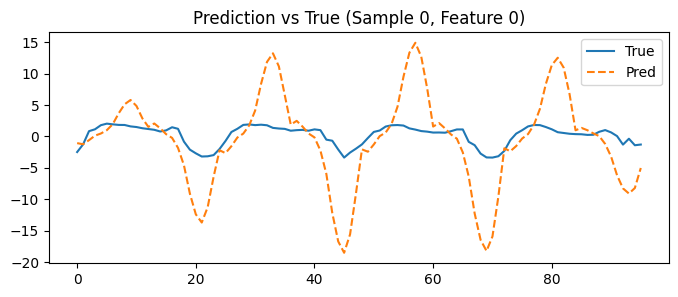

In [ ]:
def plot_prediction_vs_truth(y_true, y_pred, sample_idx=0, feature_idx=0):
    """
    y_true, y_pred: (N, pred_len, D)
    sample_idx: 테스트셋 내 몇번째 샘플 (윈도우)
    feature_idx: 변수 index (ex. 0=OT)
    """
    true_seq = y_true[sample_idx, :, feature_idx]
    pred_seq = y_pred[sample_idx, :, feature_idx]
    plt.figure(figsize=(8, 3))
    plt.plot(true_seq, label='True')
    plt.plot(pred_seq, label='Pred', linestyle='--')
    plt.title(f"Prediction vs True (Sample {sample_idx}, Feature {feature_idx})")
    plt.legend()
    plt.show()

# 사용 예시
plot_prediction_vs_truth(y_true, y_pred, sample_idx=0, feature_idx=0)


In [ ]:
def pa_at_k_percent(y_true, y_scores, k_percent):
    n = len(y_true)
    k = int(n * k_percent / 100)  # 전체 데이터의 k%에 해당하는 개수

    if k == 0:
        return 0.0

    idx_sorted = np.argsort(-y_scores)  # 이상치 점수 내림차순 정렬
    top_k_idx = idx_sorted[:k]
    pa_k = y_true[top_k_idx].sum() / k  # 상위 k개 중 실제 이상치 비율
    return pa_k

y_true = fine_tuning_test_metrics[2].flatten()  # 정답 (0:정상, 1:이상치)
y_scores = fine_tuning_test_metrics[1].flatten()  # 모델 출력 anomaly 점수 (높을수록 이상치일 확률)

# 퍼센트 값으로 설정
k_percent_values = [1, 5, 10, 20]  # 상위 1%, 5%, 10%, 20%
for k_percent in k_percent_values:
    pa_k = pa_at_k_percent(y_true, y_scores, k_percent)
    print(f"PA%{k_percent}: {pa_k:.4f}")

# 추가 정보 출력
total_anomalies = y_true.sum()
total_data = len(y_true)
anomaly_ratio = total_anomalies / total_data
print(f"\n전체 데이터 수: {total_data}")
print(f"실제 이상치 수: {total_anomalies}")
print(f"실제 이상치 비율: {anomaly_ratio:.4f}")

PA%1: 0.8613
PA%5: 0.8879
PA%10: 0.8329
PA%20: 0.6196

전체 데이터 수: 2213568
실제 이상치 수: 93903.109375
실제 이상치 비율: 0.0424


In [ ]:
def pa_at_k(y_true, y_scores, K):
    idx_sorted = np.argsort(-y_scores)  # 이상치 점수 내림차순 정렬
    top_k_idx = idx_sorted[:K]
    accuracy = y_true[top_k_idx].sum() / K
    return accuracy


In [ ]:
y_true = fine_tuning_test_metrics[2].flatten()  # 정답 (0:정상, 1:이상치)
y_scores = fine_tuning_test_metrics[1].flatten()  # 모델 출력 anomaly 점수 (높을수록 이상치일 확률)

K_values = [0, 50, 100]
for K in K_values:
    if K > 0:
        pa_k = pa_at_k(y_true, y_scores, K)
        print(f"PA@{K}: {pa_k:.4f}")


PA@50: 0.8223
PA@100: 0.9085


y_true의 고유값: [-3.7379696 -3.7317257 -3.7253036 ...  3.370874   3.4291358  3.457789 ]
y_true가 이진값이 아닙니다. 이진화가 필요합니다.
중앙값 0.07186368852853775을 임계값으로 사용하여 이진화합니다.
이진화 후 클래스 분포: 0: 1107441, 1: 1106127


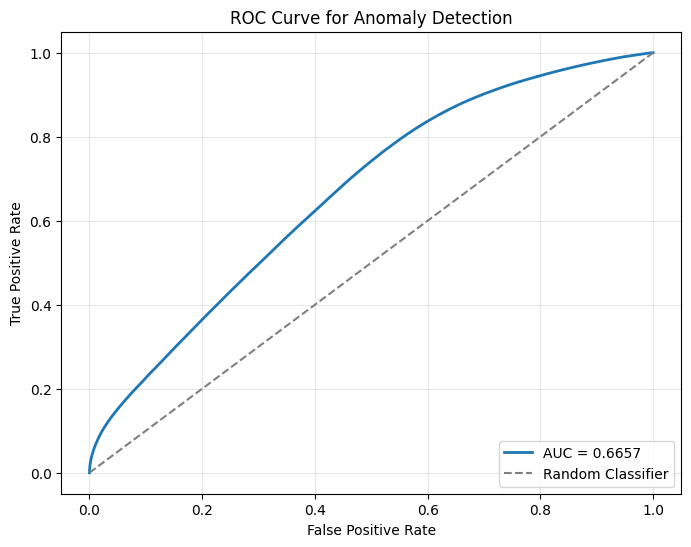

ROC-AUC score: 0.6657


(array([0.        , 0.        , 0.        , ..., 0.99990519, 0.99990519,
        1.        ]),
 array([0.00000000e+00, 9.04055321e-07, 1.34704243e-04, ...,
        9.99999096e-01, 1.00000000e+00, 1.00000000e+00]),
 array([        inf,  0.8254125 ,  0.65821916, ..., -1.0502317 ,
        -1.0507021 , -1.1818993 ], dtype=float32),
 np.float64(0.6657099338198125))

In [ ]:
def plot_roc_curve(y_true, y_scores, threshold=None):
    """
    ROC curve를 플로팅하는 함수

    Parameters:
    -----------
    y_true : array-like
        실제 라벨 (이진값 0 또는 1이어야 함)
    y_scores : array-like
        예측 점수 (연속값)
    threshold : float, optional
        연속형 y_true를 이진화할 때 사용할 임계값
    """

    # y_true가 이진값인지 확인
    unique_values = np.unique(y_true)

    if len(unique_values) > 2 or not all(val in [0, 1] for val in unique_values):
        print(f"y_true의 고유값: {unique_values}")
        print("y_true가 이진값이 아닙니다. 이진화가 필요합니다.")

        # threshold가 제공되지 않은 경우 중앙값 사용
        if threshold is None:
            threshold = np.median(y_true)
            print(f"중앙값 {threshold}을 임계값으로 사용하여 이진화합니다.")

        # 이진화 수행
        y_true_binary = (y_true > threshold).astype(int)
        print(f"이진화 후 클래스 분포: 0: {sum(y_true_binary==0)}, 1: {sum(y_true_binary==1)}")
    else:
        y_true_binary = y_true

    try:
        # ROC curve 계산
        fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
        auc_score = roc_auc_score(y_true_binary, y_scores)

        # 플롯 생성
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Anomaly Detection')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()

        print(f"ROC-AUC score: {auc_score:.4f}")

        return fpr, tpr, thresholds, auc_score

    except Exception as e:
        print(f"오류 발생: {e}")
        print("y_scores의 분포를 확인해주세요:")
        print(f"  - 범위: [{np.min(y_scores):.4f}, {np.max(y_scores):.4f}]")
        print(f"  - 고유값 개수: {len(np.unique(y_scores))}")
        return None, None, None, None
plot_roc_curve(y_true, y_scores)

# 사용 예시 1: y_true가 이미 이진값인 경우
# y_true = np.array([0, 1, 1, 0, 1, 0, 1, 0])
# y_scores = np.array([0.1, 0.8, 0.9, 0.2, 0.7, 0.3, 0.95, 0.05])
# plot_roc_curve(y_true, y_scores)

# 사용 예시 2: y_true가 연속값인 경우 (자동 이진화)
# y_true = np.array([0.1, 0.8, 0.9, 0.2, 0.7, 0.3, 0.95, 0.05])
# y_scores = np.array([0.2, 0.7, 0.8, 0.3, 0.6, 0.4, 0.9, 0.1])
# plot_roc_curve(y_true, y_scores)

# 사용 예시 3: 특정 임계값으로 이진화
# y_true = np.array([0.1, 0.8, 0.9, 0.2, 0.7, 0.3, 0.95, 0.05])
# y_scores = np.array([0.2, 0.7, 0.8, 0.3, 0.6, 0.4, 0.9, 0.1])
# plot_roc_curve(y_true, y_scores, threshold=0.5)

In [46]:
def evaluate_classification(fine_tuning_test_metrics):
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    # fine_tuning_test_metrics가 튜플이면 분리
    if isinstance(fine_tuning_test_metrics, tuple):
        print("tuple length:", len(fine_tuning_test_metrics))
        for i, v in enumerate(fine_tuning_test_metrics):
            print(f"  [{i}] type: {type(v)}, shape: {getattr(v, 'shape', None)}")

        if len(fine_tuning_test_metrics) == 4:
            avg_loss, avg_acc, all_preds, all_targets = fine_tuning_test_metrics
        else:
            print("지원하지 않는 튜플 구조입니다.")
            return
    else:
        print("결과 구조가 예상과 다름:", type(fine_tuning_test_metrics))
        print(fine_tuning_test_metrics)
        return

    print("==== [Classification Results] ====")
    acc = accuracy_score(all_targets, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds))
    cm = confusion_matrix(all_targets, all_preds)

    # Confusion Matrix 시각화
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

tuple length: 4
  [0] type: <class 'float'>, shape: None
  [1] type: <class 'float'>, shape: None
  [2] type: <class 'numpy.ndarray'>, shape: (316224,)
  [3] type: <class 'numpy.ndarray'>, shape: (316224,)
==== [Classification Results] ====
Test Accuracy: 0.2862
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10291
           1       0.51      0.00      0.01     55432
           2       0.17      0.60      0.27     34567
           3       0.13      0.09      0.11     24577
           4       0.26      0.03      0.05    108784
           5       0.40      0.78      0.53     82573
           6       0.00      0.00      0.00         0

    accuracy                           0.29    316224
   macro avg       0.21      0.21      0.14    316224
weighted avg       0.31      0.29      0.19    316224



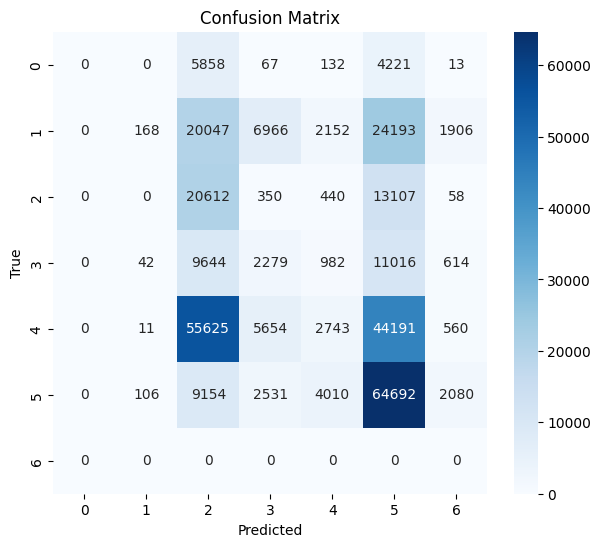

In [47]:
evaluate_classification(fine_tuning_test_metrics)


# 모델 한계점과 개선방안

## 모델한계점


*   Diffusion model 을 직접 활용했기에 2차원으로 만든 데이터 인코딩의 한계
*   비교적 깊은 모델을 사용했기에 발생하는 오버피팅 문제
*   제대로 된 Diffusion model의 경우 허용 이상의 복잡도로 인한 학습 문제  
*   다른 태스크를 기초 모델 자체의 성능에 의존하는 문제  

## 개선방안

*  1D 시계열 데이터를 합리적으로 2D 인코딩
*  1D 시계열 데이터를 이용한 Bidirectional-LSTM 혹은 BVAE 사용
*  입력 데이터 증강을 통한 오버피팅 해소
*  여타 최신 Diffusiom model에 준하는 모델 사용 및 경량화 방식 적용
*  각각의 태스크에 대한 합리적인 디코더 활용
*  부족할 수 있는 표현력을 늘리기 위한 어텐션 기초 모델 사용